# Tile test data for smooth interpolation prediction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

%run ../src/slope.py
%run ../src/utils-bilinear.py
%run ../src/dsen2/utils/DSen2Net.py

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


In [2]:
from scipy.sparse.linalg import splu
import scipy.sparse as sparse
from skimage.transform import resize

In [3]:
MDL_PATH = "../src/dsen2/models/"
INPUT_SHAPE = ((4, None, None), (6, None, None))
MODEL = s2model(INPUT_SHAPE, num_layers=6, feature_size=128)
PREDICT_FILE = MDL_PATH+'s2_032_lr_1e-04.hdf5'
MODEL.load_weights(PREDICT_FILE)

In [4]:
c_arr = np.array([[1, 1, 1, 1, 1,],
                  [1, 2, 2, 2, 1,],
                  [1, 2, 3, 2, 1,],
                  [1, 2, 2, 2, 1,],
                  [1, 1, 1, 1, 1,],])
                  
c_arr = c_arr / 3
o_arr = 1 - c_arr
c_arr = np.tile(c_arr[:, :, np.newaxis], (1, 1, 11))
o_arr = np.tile(o_arr[:, :, np.newaxis], (1, 1, 11))

In [5]:
test_files = [x for x in os.listdir("../data/test-s2/") if x in os.listdir("../data/test-s1")]
data = np.load("../data/raw/test-raw/{}".format(test_files[0]))

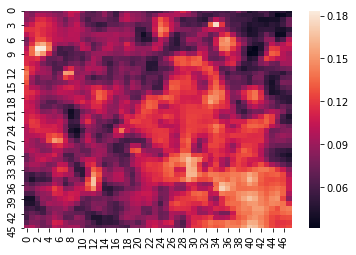

In [6]:
sns.heatmap(data[0, :, :, 2])

In [7]:
tile_lookups = { #'x_start, y_start'
    'center': [8, 8],
    'left': [0, 8],
    'right': [16, 8],
    'up': [8, 16],
    'down': [8, 0],
    'ul': [16, 0],
    'ur': [16, 16],
    'dl': [0, 0],
    'dr': [16, 0],
}

IMSIZE = 32

In [8]:
list(tile_lookups.keys())

['center', 'left', 'right', 'up', 'down', 'ul', 'ur', 'dl', 'dr']

In [9]:
def remove_missed_clouds(img):
    """ Removes steps that are likely to be missed cloud or shadows
        based on two interquartile ranges for the near infrared band
        
        Parameters:
         img (arr):

        Returns:
         to_remove (list): 
    """
    iqr = np.percentile(img[:, :, :, 3].flatten(), 75) - np.percentile(img[:, :, :, 3].flatten(), 25)
    thresh_t = np.percentile(img[:, :, :, 3].flatten(), 75) + iqr*2
    thresh_b = np.percentile(img[:, :, :, 3].flatten(), 25) - iqr*2
    diffs_fw = np.diff(img, 1, axis = 0)
    diffs_fw = np.mean(diffs_fw, axis = (1, 2, 3))
    diffs_fw = np.array([0] + list(diffs_fw))
    diffs_bw = np.diff(np.flip(img, 0), 1, axis = 0)
    diffs_bw = np.flip(np.mean(diffs_bw, axis = (1, 2, 3)))
    diffs_bw = np.array(list(diffs_bw) + [0])
    diffs = abs(diffs_fw - diffs_bw) * 100 # 3, -3 -> 6, -3, 3 -> 6, -3, -3
    #diffs = [int(x) for x in diffs]
    outlier_percs = []
    for step in range(img.shape[0]):
        bottom = len(np.argwhere(img[step, :, :, 3].flatten() > thresh_t))
        top = len(np.argwhere(img[step, :, :, 3].flatten() < thresh_b))
        p = 100* ((bottom + top) / (48*48))
        outlier_percs.append(p)
    print(outlier_percs)
    to_remove = np.argwhere(np.array(outlier_percs) > 15)
    return to_remove

def remove_bad_steps(img, probs, shadows, image_dates):
    shadow_sums = np.sum(shadows, axis = (1, 2))
    shadow_steps = np.argwhere(shadow_sums > (48*48/3))
    #probs = np.mean(probs, axis = (1, 2))
    args = np.array([len(np.argwhere(probs[x].flatten() > 0.3)) for x in range(probs.shape[0])])
    dirty_steps = np.argwhere(args > (48)*(48) / 5)
    missing_images = [np.argwhere(img[x, :, : :].flatten() == 0.0) for x in range(img.shape[0])]
    missing_images = np.array([len(x) for x in missing_images])
    missing_images_p = [np.argwhere(img[x, :, : :].flatten() >= 1) for x in range(img.shape[0])]
    missing_images_p = np.array([len(x) for x in missing_images_p])
    missing_images += missing_images_p
    missing_images = list(np.argwhere(missing_images >= 25))
    to_remove = np.unique(np.array(list(dirty_steps) + list(missing_images) + list(shadow_steps)))

    # Remove null steps
    print("There are {}/{} dirty steps: {}"
          " cloud, {} missing, {} shadow".format(len(to_remove),
                                                 len(img), len(dirty_steps),
                                                 len(missing_images),
                                                 len(shadow_steps)))

    img = np.delete(img, to_remove, 0)
    probs = np.delete(probs, to_remove, 0)
    image_dates = np.delete(image_dates, to_remove)
    shadows = np.delete(shadows, to_remove, 0)

    to_remove = remove_missed_clouds(img)
    img = np.delete(img, to_remove, 0)
    probs = np.delete(probs, to_remove, 0)
    image_dates = np.delete(image_dates, to_remove)
    shadows = np.delete(shadows, to_remove, 0)
    print("Removing {} steps based on ratio".format(len(to_remove)))
    return img, probs, image_dates, shadows
    
def DSen2(d10, d20):
    """Super resolves 20 meter bans using the DSen2 convolutional
       neural network, as specified in Lanaras et al. 2018
       https://github.com/lanha/DSen2

        Parameters:
         d10 (arr): (4, X, Y) shape array with 10 meter resolution
         d20 (arr): (6, X, Y) shape array with 20 meter resolution

        Returns:
         prediction (arr): (6, X, Y) shape array with 10 meter superresolved
                          output of DSen2 on d20 array
    """
    test = [d10, d20]
    input_shape = ((4, None, None), (6, None, None))
    prediction = _predict(test, input_shape, deep=False)
    #prediction *= 5
    return prediction

def _predict(test, input_shape, model = MODEL, deep=False, run_60=False):
    
    prediction = model.predict(test, verbose=1)
    return prediction

def calculate_proximal_steps_index(date, satisfactory):
    """Returns proximal steps that are cloud and shadow free

         Parameters:
          date (int): current time step
          satisfactory (list): time steps with no clouds or shadows

         Returns:
          arg_before (str): index of the prior clean image
          arg_after (int): index of the next clean image
    """
    arg_before, arg_after = None, None
    if date > 0:
        idx_before = satisfactory - date
        arg_before = idx_before[np.where(idx_before < 0, idx_before, -np.inf).argmax()]
    if date < np.max(satisfactory):
        idx_after = satisfactory - date
        arg_after = idx_after[np.where(idx_after > 0, idx_after, np.inf).argmin()]
    if not arg_after and not arg_before:
        arg_after = date
        arg_before = date
    if not arg_after:
        arg_after = arg_before
    if not arg_before:
        arg_before = arg_after
    return arg_before, arg_after

def speyediff(N, d, format = 'csc'):
    """Calculates the d-th order sparse difference matrix based on 
       an initial N x N identity matrix

         Parameters:
          N (int): input length
          d (int): smoothing order

         Returns:
          spmat (arr): sparse difference matrix
    """
    shape = (N-d, N)
    diagonals = np.zeros(2*d + 1)
    diagonals[d] = 1.
    for i in range(d):
        diff = diagonals[:-1] - diagonals[1:]
        diagonals = diff
    offsets = np.arange(d+1)
    spmat = sparse.diags(diagonals, offsets, shape, format = format)
    return spmat

def smooth(y, lmbd, d = 2):
    """Calculates the whittaker smoother on input array

         Parameters:
          y (arr): 1-dimensional input array
          lmbd (int): degree of smoothing, higher is more

         Returns:
          z (arr): smoothed version of y
    """
    m = len(y)
    E = sparse.eye(m, format = 'csc')
    D = speyediff(m, d, format = 'csc')
    coefmat = E + lmbd * D.conj().T.dot(D)
    z = splu(coefmat).solve(y)
    return z


def superresolve(arr):
    print("Shape before super: {}".format(arr.shape))

    d10 = arr[:, :, :, 0:4]
    d20 = arr[:, :, :, 4:10]

    d10 = np.swapaxes(d10, 1, -1)
    d10 = np.swapaxes(d10, 2, 3)
    d20 = np.swapaxes(d20, 1, -1)
    d20 = np.swapaxes(d20, 2, 3)
    superresolved = DSen2(d10, d20)
    superresolved = np.swapaxes(superresolved, 1, -1)
    superresolved = np.swapaxes(superresolved, 1, 2)
    print(superresolved.shape)
    print(arr.shape)

    # returns band IDXs 3, 4, 5, 7, 8, 9
    arr[:, :, :, 4:10] = superresolved
    print("Shape after super: {}".format(arr.shape))
    return arr

def calculate_and_save_best_images(img_bands, image_dates):
    """ Interpolate input data of (Time, X, Y, Band) to a constant
        (72, X, Y, Band) shape with one time step every five days
        
        Parameters:
         img_bands (arr):
         image_dates (list):
         
        Returns:
         keep_steps (arr):
         max_distance (int)
    """
    biweekly_dates = [day for day in range(0, 360, 5)] # ideal imagery dates are every 15 days
    
    # Clouds have been removed at this step, so all steps are satisfactory
    satisfactory_ids = [x for x in range(0, img_bands.shape[0])]
    satisfactory_dates = [value for idx, value in enumerate(image_dates) if idx in satisfactory_ids]
    
    
    selected_images = {}
    for i in biweekly_dates:
        distances = [abs(date - i) for date in satisfactory_dates]
        closest = np.min(distances)
        closest_id = np.argmin(distances)
        # If there is imagery within 5 days, select it
        if closest < 8:
            date = satisfactory_dates[closest_id]
            image_idx = int(np.argwhere(np.array(image_dates) == date)[0])
            selected_images[i] = {'image_date': [date], 'image_ratio': [1], 'image_idx': [image_idx]}
        # If there is not imagery within 7 days, look for the closest above and below imagery
        else:
            distances = np.array([(date - i) for date in satisfactory_dates])
            # Number of days above and below the selected date of the nearest clean imagery
            above = distances[np.where(distances < 0, distances, -np.inf).argmax()]
            below = distances[np.where(distances > 0, distances, np.inf).argmin()]
            if abs(above) > 240: # If date is the last date, occassionally argmax would set above to - number
                above = below
            if abs(below) > 240:
                below = above
            if above != below:
                below_ratio = above / (above - below)
                above_ratio = 1 - below_ratio
            else:
                above_ratio = below_ratio = 0.5
                
            # Extract the image date and imagery index for the above and below values
            above_date = i + above
            above_image_idx = int(np.argwhere(np.array(image_dates) == above_date)[0])
            
            below_date = i + below
            below_image_idx = int(np.argwhere(np.array(image_dates) == below_date)[0])
            
            selected_images[i] = {'image_date': [above_date, below_date], 'image_ratio': [above_ratio, below_ratio],
                                 'image_idx': [above_image_idx, below_image_idx]}
                               
    max_distance = 0
    
    for i in selected_images.keys():
        #print(i, selected_images[i])
        if len(selected_images[i]['image_date']) == 2:
            dist = selected_images[i]['image_date'][1] - selected_images[i]['image_date'][0]
            if dist > max_distance:
                max_distance = dist
    
    print("Maximum time distance: {}".format(max_distance))
        
    # Compute the weighted average of the selected imagery for each time step
    keep_steps = []
    use_median = False
    for i in selected_images.keys():
        step1_additional = None
        step2_additional = None
        info = selected_images[i]
        if len(info['image_idx']) == 1:
            step = img_bands[info['image_idx'][0]]
        if len(info['image_idx']) == 2:
            step1 = img_bands[info['image_idx'][0]] # * info['image_ratio'][0]
            step2 = img_bands[info['image_idx'][1]]
            step = step1 * 0.5 + step2 * 0.5
        keep_steps.append(step)
        
    keep_steps = np.stack(keep_steps)
    return keep_steps, max_distance

def remove_cloud_and_shadows(tiles, probs, shadows, image_dates, wsize = 5):
    """ Interpolates clouds and shadows for each time step with 
        linear combination of proximal clean time steps for each
        region of specified window size
        
        Parameters:
         tiles (arr):
         probs (arr): 
         shadows (arr):
         image_dates (list):
         wsize (int): 
    
        Returns:
         tiles (arr): 
    """
    c_probs = np.copy(probs)
    c_probs = c_probs - np.min(c_probs, axis = 0)
    c_probs[np.where(c_probs > 0.33)] = 1.
    c_probs[np.where(c_probs < 0.33)] = 0.
    c_probs = np.reshape(c_probs, [c_probs.shape[0], int(48/8), 8, int(48/8), 8])
    c_probs = np.sum(c_probs, (2, 4))
    c_probs = resize(c_probs, (c_probs.shape[0], 48, 48), 0)
    c_probs[np.where(c_probs < 12)] = 0.
    c_probs[np.where(c_probs >= 12)] = 1.
    c_probs += shadows
    c_probs[np.where(c_probs >= 1.)] = 1.
    n_interp = 0
    for cval in range(0, 48 - 5, 1):
        for rval in range(0, 48 - 5, 1):
            subs = c_probs[:, cval:cval + wsize, rval:rval+wsize]
            satisfactory = [x for x in range(c_probs.shape[0]) if np.sum(subs[x, :, :]) < 10]
            satisfactory = np.array(satisfactory)
            for date in range(0, tiles.shape[0]):
                if np.sum(subs[date, :, :]) > 10:
                    n_interp += 1
                    before, after = calculate_proximal_steps_index(date, satisfactory)
                    before = date + before
                    after = date + after
                    if after >= tiles.shape[0]:
                        after = before
                    if before < 0:
                        before = after
                    bef = tiles[before, cval:cval+wsize, rval:rval+wsize, : ]
                    aft = tiles[after, cval:cval+wsize, rval:rval+wsize, : ]
                    before = image_dates[before]
                    after = image_dates[after]
                    before_diff = abs(image_dates[date] - before)
                    after_diff = abs(image_dates[date] - after)
                    bef_wt = 1 - before_diff / (before_diff + after_diff)
                    aft_wt = 1 - bef_wt
                    candidate = bef_wt*bef + aft_wt*aft
                    candidate = candidate*c_arr + tiles[date, cval:cval+wsize, rval:rval+wsize, : ]*o_arr
                    tiles[date, cval:cval+wsize, rval:rval+wsize, : ] = candidate  
    print("Interpolated {} px".format(n_interp))
    return tiles


def process_array(plot_id):
    starting_days = np.cumsum([0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30])
    YEAR = 2019
    s2 = np.load('../data/raw/test-raw/{}.npy'.format(plot_id))
    shadows = np.load('../data/raw/test-shadows/{}.npy'.format(plot_id))
    clouds = np.load('../data/raw/test-clouds/{}.npy'.format(plot_id))
    dates = np.load('../data/raw/test-dates/{}.npy'.format(plot_id), allow_pickle = True)
    s1 = np.load("../data/raw/test-s1/{}.npy".format(plot_id))
    dem = np.load("../data/raw/test-dem/{}.npy".format(plot_id))
    
    print("BEF", s2.shape)
    print("BEF", clouds.shape)
    print("BEF", dates.shape)
    image_dates = []
    for date in dates:
        if date.year == YEAR - 1:
            image_dates.append(-365 + starting_days[(date.month-1)] + date.day)
        if date.year == YEAR:
            image_dates.append(starting_days[(date.month-1)] + date.day)
        if date.year == YEAR + 1:
            image_dates.append(365 + starting_days[(date.month-1)]+date.day)
    dates = np.array(image_dates)
    
    print("BEF", s2.shape)
    print("BEF", clouds.shape)
    # subset time steps
    s2, clouds, dates, shadows = remove_bad_steps(s2, clouds, shadows, dates)
    print("AFT", s2.shape)
    print("AFT", clouds.shape)
    
    # Concatenate DEM
    dem = np.tile(dem.reshape((1, 48, 48, 1)), (s2.shape[0], 1, 1, 1))
    s2 = np.concatenate([s2, dem], axis = -1)
    s2[:, :, :, -1] /= 90
    
    # remove clouds and shadows
    print(s2.shape)
    print(clouds.shape)
    print(shadows.shape)
    s2 = remove_cloud_and_shadows(s2, clouds, shadows, dates)
    
    # super resolve
    s2 = superresolve(s2)
    
    
    # indices
    s2, amin = evi(s2, True)
    s2 = bi(s2, True)
    s2 = msavi2(s2, True)
    s2 = si(s2, True)
    
    s2 = s2[:, 8:40, 8:40, :]


    
    # whittaker smooth
    # Smooth linear interpolation
    for row in range(0, 32):
        for column in range(0, 32):
            for band in [x for x in range(0, 15) if x != 10]:
                sm = smooth(s2[:, row, column, band], 800, d = 2)
                s2[:, row, column, band] = sm
    
    s2, _ = calculate_and_save_best_images(s2, dates)
    biweekly_dates = np.array([day for day in range(0, 360, 5)])
    to_remove = np.argwhere(biweekly_dates % 15 != 0)
    s2 = np.delete(s2, to_remove, 0)
    fused = np.concatenate([s1, s2], axis = -1)
    # save fused data
    np.save("../data/raw/test-processed/{}.npy".format(plot_id), fused)
    #print(fused.shape)
    #windows = make_5d_array(fused, tile_lookups)
    #return windows
    # return (24, 32, 32, 16) array

def make_5d_array(arr, tile_lookups):
    arr_5d = np.empty((9, 24, 16, 16, 17))
    print(arr.shape)
    for i in range(len(tile_lookups.keys())):
        key = list(tile_lookups.keys())[i]
        start_x = tile_lookups[key][0]
        start_y = tile_lookups[key][1]
        arr_5d[i] = arr[:24, start_x:start_x+16, start_y:start_y+16, :]
    return arr_5d

def reconstruct_array(arr):
    
    out = np.copy(arr[0])
    
    center = arr[0]
    left = arr[1]
    right = arr[2]
    up = arr[3]
    down = arr[4]
    ul = arr[5]
    ur = arr[6]
    dl = arr[7]
    dr = arr[8]
    
    out[:, :8, :, :] = (center[:, :8, :, :] + left[:, 8:, :, :]) / 2
    print(np.sum(out) - np.sum(center))
    out[:, 8:, :, :] = (center[:, 8:, :, :] + right[:, :8, :, :]) / 2
    print(np.sum(out) - np.sum(center))
    out[:, :, 8:, :] = (center[:, :, 8:, :] + up[:, :, :8, :]) / 2
    print(np.sum(out) - np.sum(center))
    out[:, :, :8, :] = (center[:, :, :8, :] + down[:, :, 8:, :]) / 2
    print(np.sum(out) - np.sum(center))

In [26]:
to_process = [x for x in os.listdir("../data/raw/test-raw/")]
to_process = [x for x in to_process if x  in os.listdir("../data/raw/test-s1/")]
to_process = [str(x[:-4]) for x in  to_process if x not in os.listdir("../data/raw/test-processed/")]
for i in to_process:
    process_array(i)
#map(process_array, to_process)
#windows = process_array("135804022")    
        
#data_5d = make_5d_array(data, tile_lookups)
#reconstruct_array(data_5d)

BEF (61, 48, 48, 10)
BEF (61, 48, 48)
BEF (61,)
BEF (61, 48, 48, 10)
BEF (61, 48, 48)
There are 19/61 dirty steps: 19 cloud, 2 missing, 0 shadow
[0.08680555555555555, 0.08680555555555555, 0.0, 0.0, 0.13020833333333331, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.043402777777777776, 0.13020833333333331, 0.0, 0.0, 0.08680555555555555, 0.0, 0.0, 0.0, 0.2170138888888889, 2.170138888888889, 0.043402777777777776, 0.043402777777777776, 0.0, 0.0, 0.13020833333333331, 0.0, 0.043402777777777776, 0.0, 0.08680555555555555, 0.043402777777777776]
Removing 0 steps based on ratio
AFT (42, 48, 48, 10)
AFT (42, 48, 48)
(42, 48, 48, 11)
(42, 48, 48)
(42, 48, 48)
Interpolated 803 px
Shape before super: (42, 48, 48, 11)
42/42 [==============================] - 3s 73ms/step
(42, 48, 48, 6)
(42, 48, 48, 11)
Shape after super: (42, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 115
BEF (60, 48, 48, 10)
BEF (60, 48, 48)
BEF (60,)
BEF (60, 48, 48, 10

Interpolated 2662 px
Shape before super: (36, 48, 48, 11)
36/36 [==============================] - 3s 75ms/step
(36, 48, 48, 6)
(36, 48, 48, 11)
Shape after super: (36, 48, 48, 11)
There are: 0 out of bounds EVI
()
evis error: 0.16486766934394836, 1.1968610286712646, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 55
BEF (71, 48, 48, 10)
BEF (75, 48, 48)
BEF (71,)
BEF (71, 48, 48, 10)
BEF (75, 48, 48)
There are 31/71 dirty steps: 28 cloud, 9 missing, 2 shadow
[2.907986111111111, 0.9548611111111112, 5.295138888888888, 0.13020833333333331, 0.043402777777777776, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.043402777777777776, 0.0, 0.043402777777777776, 0.08680555555555555, 0.08680555555555555, 0.08680555555555555, 0.13020833333333331, 61.848958333333336, 1.6493055555555556, 0.0, 0.1736111111111111, 7.204861111111111, 2.039930555555556, 4.036458333333334, 14.27951388888889, 10.677083333333332, 21.65798611111111, 100.0, 100.0, 58.072916666666664, 0.4340277777777778, 0.0, 0.0, 0.04340277777777

Interpolated 698 px
Shape before super: (63, 48, 48, 11)
63/63 [==============================] - 5s 75ms/step
(63, 48, 48, 6)
(63, 48, 48, 11)
Shape after super: (63, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 25
BEF (68, 48, 48, 10)
BEF (68, 48, 48)
BEF (68,)
BEF (68, 48, 48, 10)
BEF (68, 48, 48)
There are 25/68 dirty steps: 23 cloud, 4 missing, 3 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6944444444444444, 4.991319444444445, 0.0, 0.0, 0.08680555555555555, 0.4774305555555556, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5208333333333333, 0.0, 0.0, 0.0]
Removing 0 steps based on ratio
AFT (43, 48, 48, 10)
AFT (43, 48, 48)
(43, 48, 48, 11)
(43, 48, 48)
(43, 48, 48)
Interpolated 1308 px
Shape before super: (43, 48, 48, 11)
43/43 [==============================] - 4s 85ms/step
(43, 48, 48, 6)
(43, 48, 48, 11)
Shape after super: (43, 48, 48, 11)
There are: 0 out of bounds EVI
()

Interpolated 112 px
Shape before super: (62, 48, 48, 11)
62/62 [==============================] - 5s 77ms/step
(62, 48, 48, 6)
(62, 48, 48, 11)
Shape after super: (62, 48, 48, 11)
There are: 0 out of bounds EVI
()
evis error: 0.11909835040569305, 1.0023674964904785, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 20
BEF (71, 48, 48, 10)
BEF (71, 48, 48)
BEF (71,)
BEF (71, 48, 48, 10)
BEF (71, 48, 48)
There are 12/71 dirty steps: 11 cloud, 4 missing, 0 shadow
[0.8680555555555556, 4.079861111111112, 0.6944444444444444, 1.6059027777777777, 2.647569444444444, 1.519097222222222, 0.13020833333333331, 0.08680555555555555, 0.9548611111111112, 0.0, 0.0, 0.26041666666666663, 0.0, 0.043402777777777776, 0.1736111111111111, 0.0, 0.1736111111111111, 0.13020833333333331, 0.13020833333333331, 0.13020833333333331, 0.3038194444444445, 0.13020833333333331, 0.08680555555555555, 0.08680555555555555, 0.043402777777777776, 0.1736111111111111, 0.3472222222222222, 0.043402777777777776, 0.4774305555555556

Interpolated 78 px
Shape before super: (32, 48, 48, 11)
32/32 [==============================] - 2s 72ms/step
(32, 48, 48, 6)
(32, 48, 48, 11)
Shape after super: (32, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 100
BEF (62, 48, 48, 10)
BEF (62, 48, 48)
BEF (62,)
BEF (62, 48, 48, 10)
BEF (62, 48, 48)
There are 36/62 dirty steps: 36 cloud, 1 missing, 0 shadow
[0.4340277777777778, 4.210069444444445, 0.8680555555555556, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3038194444444445, 0.0, 0.0, 0.0, 0.0, 0.3472222222222222, 1.6493055555555556, 0.78125, 0.08680555555555555]
Removing 0 steps based on ratio
AFT (26, 48, 48, 10)
AFT (26, 48, 48)
(26, 48, 48, 11)
(26, 48, 48)
(26, 48, 48)
Interpolated 264 px
Shape before super: (26, 48, 48, 11)
26/26 [==============================] - 2s 71ms/step
(26, 48, 48, 6)
(26, 48, 48, 11)
Shape after super: (26, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 45
BEF (62, 48, 48, 10)
BEF (62

Interpolated 2195 px
Shape before super: (49, 48, 48, 11)
49/49 [==============================] - 3s 70ms/step
(49, 48, 48, 6)
(49, 48, 48, 11)
Shape after super: (49, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 30
BEF (75, 48, 48, 10)
BEF (75, 48, 48)
BEF (75,)
BEF (75, 48, 48, 10)
BEF (75, 48, 48)
There are 12/75 dirty steps: 12 cloud, 2 missing, 0 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.46875]
Removing 0 steps based on ratio
AFT (63, 48, 48, 10)
AFT (63, 48, 48)
(63, 48, 48, 11)
(63, 48, 48)
(63, 48, 48)
Interpolated 564 px
Shape before super: (63, 48, 48, 11)
63/63 [==============================] - 5s 73ms/step
(63, 48, 48, 6)
(63, 48, 48, 11)
Shape after super: (63, 48, 48, 11)
Ther

Interpolated 453 px
Shape before super: (41, 48, 48, 11)
41/41 [==============================] - 3s 77ms/step
(41, 48, 48, 6)
(41, 48, 48, 11)
Shape after super: (41, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 50
BEF (69, 48, 48, 10)
BEF (69, 48, 48)
BEF (69,)
BEF (69, 48, 48, 10)
BEF (69, 48, 48)
There are 40/69 dirty steps: 40 cloud, 4 missing, 0 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13020833333333331, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Removing 0 steps based on ratio
AFT (29, 48, 48, 10)
AFT (29, 48, 48)
(29, 48, 48, 11)
(29, 48, 48)
(29, 48, 48)
Interpolated 1572 px
Shape before super: (29, 48, 48, 11)
29/29 [==============================] - 2s 70ms/step
(29, 48, 48, 6)
(29, 48, 48, 11)
Shape after super: (29, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 40
BEF (67, 48, 48, 10)
BEF (67, 48, 48)
BEF (67,)
BEF (67, 48, 48, 10)
BEF (67, 48, 48)
There are 17/67 dir

/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Interpolated 284 px
Shape before super: (18, 48, 48, 11)
18/18 [==============================] - 1s 76ms/step
(18, 48, 48, 6)
(18, 48, 48, 11)
Shape after super: (18, 48, 48, 11)
There are: 118 out of bounds EVI
()
evis error: -4458.94482421875, 1033.5489501953125, 1 steps, clipping to -1.5, 1.5
Maximum time distance: 63
BEF (63, 48, 48, 10)
BEF (63, 48, 48)
BEF (63,)
BEF (63, 48, 48, 10)
BEF (63, 48, 48)
There are 16/63 dirty steps: 16 cloud, 4 missing, 0 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.043402777777777776, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.9097222222222223, 0.0, 0.0, 5.164930555555555, 0.0, 0.2170138888888889, 0.0, 0.0, 0.0, 16.666666666666664, 30.598958333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.928819444444445, 0.0, 0.4774305555555556, 0.1736111111111111, 0.0, 0.0, 0.0]
Removing 3 steps based on ratio
AFT (44, 48, 48, 10)
AFT (44, 48, 48)
(44, 48, 48, 11)
(44, 48, 48)
(44, 48, 48)
Interpolated 160 px
Shape before super: (44, 4

Interpolated 1027 px
Shape before super: (39, 48, 48, 11)
39/39 [==============================] - 3s 75ms/step
(39, 48, 48, 6)
(39, 48, 48, 11)
Shape after super: (39, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 60
BEF (47, 48, 48, 10)
BEF (47, 48, 48)
BEF (47,)
BEF (47, 48, 48, 10)
BEF (47, 48, 48)
There are 28/47 dirty steps: 28 cloud, 1 missing, 0 shadow
[0.4340277777777778, 0.0, 0.0, 0.607638888888889, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08680555555555555, 0.2170138888888889, 1.128472222222222, 0.08680555555555555]
Removing 0 steps based on ratio
AFT (19, 48, 48, 10)
AFT (19, 48, 48)
(19, 48, 48, 11)
(19, 48, 48)
(19, 48, 48)
Interpolated 563 px
Shape before super: (19, 48, 48, 11)
19/19 [==============================] - 1s 68ms/step
(19, 48, 48, 6)
(19, 48, 48, 11)
Shape after super: (19, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 45
BEF (54, 48, 48, 10)
BEF (54, 48, 48)
BEF (54,)
BEF (54, 48, 48, 10)
BEF (54, 48,

Interpolated 1363 px
Shape before super: (47, 48, 48, 11)
47/47 [==============================] - 3s 68ms/step
(47, 48, 48, 6)
(47, 48, 48, 11)
Shape after super: (47, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 40
BEF (65, 48, 48, 10)
BEF (65, 48, 48)
BEF (65,)
BEF (65, 48, 48, 10)
BEF (65, 48, 48)
There are 25/65 dirty steps: 25 cloud, 7 missing, 0 shadow
[0.0, 0.9982638888888888, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.123263888888888, 0.043402777777777776, 0.0, 0.0, 0.0, 0.0, 11.197916666666668, 0.0, 0.0, 0.0, 0.0]
Removing 0 steps based on ratio
AFT (40, 48, 48, 10)
AFT (40, 48, 48)
(40, 48, 48, 11)
(40, 48, 48)
(40, 48, 48)
Interpolated 821 px
Shape before super: (40, 48, 48, 11)
40/40 [==============================] - 3s 70ms/step
(40, 48, 48, 6)
(40, 48, 48, 11)
Shape after super: (40, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 85
BEF (

Interpolated 0 px
Shape before super: (24, 48, 48, 11)
24/24 [==============================] - 2s 75ms/step
(24, 48, 48, 6)
(24, 48, 48, 11)
Shape after super: (24, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 45
BEF (78, 48, 48, 10)
BEF (78, 48, 48)
BEF (78,)
BEF (78, 48, 48, 10)
BEF (78, 48, 48)
There are 15/78 dirty steps: 14 cloud, 1 missing, 0 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.26041666666666663, 17.578125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.390625, 0.08680555555555555, 0.1736111111111111, 0.0, 0.0, 0.0, 0.043402777777777776, 0.0, 0.0, 2.734375, 4.296875, 4.6875, 13.28125, 14.800347222222221, 36.06770833333333, 38.71527777777778, 38.62847222222222, 34.50520833333333, 23.914930555555554, 17.491319444444446, 0.390625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.23958333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Removing 8 steps based on ratio
AFT (55, 48, 48, 10)
AFT (55, 48, 48)
(55, 48, 48, 11)
(55,

Interpolated 121 px
Shape before super: (45, 48, 48, 11)
45/45 [==============================] - 3s 74ms/step
(45, 48, 48, 6)
(45, 48, 48, 11)
Shape after super: (45, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 85
BEF (64, 48, 48, 10)
BEF (64, 48, 48)
BEF (64,)
BEF (64, 48, 48, 10)
BEF (64, 48, 48)
There are 11/64 dirty steps: 10 cloud, 2 missing, 0 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.13020833333333331, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.043402777777777776, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13020833333333331, 0.08680555555555555, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1736111111111111, 0.1736111111111111, 0.13020833333333331, 0.0, 0.0, 0.043402777777777776, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13020833333333331, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Removing 0 steps based on ratio
AFT (53, 48, 48, 10)
AFT (53, 48, 48)
(53, 48, 48, 11)
(53, 48, 48)
(53, 48, 48)
Interpolated 431 px
Shape before super: (53, 48, 48, 11)
53/53 [==============================]

Interpolated 453 px
Shape before super: (46, 48, 48, 11)
46/46 [==============================] - 3s 71ms/step
(46, 48, 48, 6)
(46, 48, 48, 11)
Shape after super: (46, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 135
BEF (70, 48, 48, 10)
BEF (70, 48, 48)
BEF (70,)
BEF (70, 48, 48, 10)
BEF (70, 48, 48)
There are 29/70 dirty steps: 29 cloud, 3 missing, 0 shadow
[0.26041666666666663, 0.1736111111111111, 0.0, 0.1736111111111111, 0.043402777777777776, 0.043402777777777776, 0.6944444444444444, 0.607638888888889, 0.3472222222222222, 1.6927083333333333, 2.430555555555556, 0.3038194444444445, 1.6059027777777777, 0.4340277777777778, 0.0, 0.1736111111111111, 0.13020833333333331, 0.0, 0.08680555555555555, 0.0, 0.0, 0.0, 0.0, 0.13020833333333331, 0.08680555555555555, 0.13020833333333331, 0.0, 0.0, 0.0, 0.0, 1.2586805555555556, 2.213541666666667, 12.152777777777777, 17.92534722222222, 0.043402777777777776, 0.0, 0.0, 0.1736111111111111, 0.2170138888888889, 2.994791666666667, 2.86

(32, 48, 48, 6)
(32, 48, 48, 11)
Shape after super: (32, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 40
BEF (45, 48, 48, 10)
BEF (45, 48, 48)
BEF (45,)
BEF (45, 48, 48, 10)
BEF (45, 48, 48)
There are 29/45 dirty steps: 29 cloud, 5 missing, 0 shadow
[2.821180555555556, 2.517361111111111, 1.7795138888888888, 1.3020833333333335, 0.390625, 0.3472222222222222, 2.256944444444444, 1.8229166666666667, 2.039930555555556, 15.668402777777779, 5.251736111111112, 0.8246527777777778, 0.9982638888888888, 1.6059027777777777, 0.4340277777777778, 0.6510416666666667]
Removing 1 steps based on ratio
AFT (15, 48, 48, 10)
AFT (15, 48, 48)
(15, 48, 48, 11)
(15, 48, 48)
(15, 48, 48)
Interpolated 77 px
Shape before super: (15, 48, 48, 11)
15/15 [==============================] - 1s 63ms/step
(15, 48, 48, 6)
(15, 48, 48, 11)
Shape after super: (15, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 255
BEF (55, 48, 48, 10)
BEF (55, 48, 48)
BEF (55,)
BEF (55, 48, 48, 10)
BEF 

Interpolated 1821 px
Shape before super: (23, 48, 48, 11)
23/23 [==============================] - 2s 72ms/step
(23, 48, 48, 6)
(23, 48, 48, 11)
Shape after super: (23, 48, 48, 11)
There are: 1 out of bounds EVI
()
evis error: -0.04441894590854645, 3.3151321411132812, 1 steps, clipping to -1.5, 1.5
Maximum time distance: 45
BEF (71, 48, 48, 10)
BEF (71, 48, 48)
BEF (71,)
BEF (71, 48, 48, 10)
BEF (71, 48, 48)
There are 37/71 dirty steps: 37 cloud, 15 missing, 0 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.213541666666668, 11.371527777777777, 8.897569444444445, 1.5625, 4.557291666666666, 0.3038194444444445, 3.038194444444444, 0.1736111111111111, 0.08680555555555555, 0.043402777777777776, 0.13020833333333331, 0.0, 0.043402777777777776, 0.0]
Removing 1 steps based on ratio
AFT (33, 48, 48, 10)
AFT (33, 48, 48)
(33, 48, 48, 11)
(33, 48, 48)
(33, 48, 48)
Interpolated 1650 px
Shape before super: (33, 48, 48, 11)
33/33 [========

Interpolated 60 px
Shape before super: (49, 48, 48, 11)
49/49 [==============================] - 3s 71ms/step
(49, 48, 48, 6)
(49, 48, 48, 11)
Shape after super: (49, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 75
BEF (73, 48, 48, 10)
BEF (73, 48, 48)
BEF (73,)
BEF (73, 48, 48, 10)
BEF (73, 48, 48)
There are 10/73 dirty steps: 10 cloud, 0 missing, 0 shadow
[0.4340277777777778, 0.3472222222222222, 0.564236111111111, 0.4774305555555556, 1.215277777777778, 0.5208333333333333, 0.8246527777777778, 0.607638888888889, 0.26041666666666663, 0.390625, 0.1736111111111111, 0.1736111111111111, 0.2170138888888889, 3.4288194444444446, 0.0, 0.043402777777777776, 0.0, 0.0, 0.0, 0.0, 32.89930555555556, 0.0, 0.043402777777777776, 0.0, 0.6510416666666667, 8.506944444444445, 1.8663194444444444, 5.946180555555555, 8.37673611111111, 3.6024305555555554, 0.564236111111111, 0.08680555555555555, 0.26041666666666663, 0.0, 0.0, 0.0, 0.0, 0.043402777777777776, 0.043402777777777776, 0.0, 0.0, 0

Interpolated 283 px
Shape before super: (46, 48, 48, 11)
46/46 [==============================] - 3s 75ms/step
(46, 48, 48, 6)
(46, 48, 48, 11)
Shape after super: (46, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 100
BEF (76, 48, 48, 10)
BEF (76, 48, 48)
BEF (76,)
BEF (76, 48, 48, 10)
BEF (76, 48, 48)
There are 16/76 dirty steps: 16 cloud, 0 missing, 0 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.618055555555554, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.204861111111111, 0.0, 0.0, 0.2170138888888889, 0.0, 0.0, 6.640625]
Removing 1 steps based on ratio
AFT (59, 48, 48, 10)
AFT (59, 48, 48)
(59, 48, 48, 11)
(59, 48, 48)
(59, 48, 48)
Interpolated 207 px
Shape before super: (59, 48, 48, 11)
59/59 [==============================] - 4s 72ms/step
(59, 48, 48, 6)
(59, 48, 48, 11)
Shape afte

Maximum time distance: 30
BEF (64, 48, 48, 10)
BEF (64, 48, 48)
BEF (64,)
BEF (64, 48, 48, 10)
BEF (64, 48, 48)
There are 45/64 dirty steps: 40 cloud, 5 missing, 6 shadow
[0.08680555555555555, 0.0, 1.3020833333333335, 0.0, 0.0, 0.0, 4.991319444444445, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Removing 0 steps based on ratio
AFT (19, 48, 48, 10)
AFT (19, 48, 48)
(19, 48, 48, 11)
(19, 48, 48)
(19, 48, 48)
Interpolated 1313 px
Shape before super: (19, 48, 48, 11)
19/19 [==============================] - 1s 66ms/step
(19, 48, 48, 6)
(19, 48, 48, 11)
Shape after super: (19, 48, 48, 11)
There are: 9 out of bounds EVI
()
evis error: -28.366430282592773, 4.670175552368164, 2 steps, clipping to -1.5, 1.5
Maximum time distance: 100
BEF (65, 48, 48, 10)
BEF (65, 48, 48)
BEF (65,)
BEF (65, 48, 48, 10)
BEF (65, 48, 48)
There are 15/65 dirty steps: 15 cloud, 1 missing, 0 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

Interpolated 684 px
Shape before super: (49, 48, 48, 11)
49/49 [==============================] - 3s 69ms/step
(49, 48, 48, 6)
(49, 48, 48, 11)
Shape after super: (49, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 20
BEF (72, 48, 48, 10)
BEF (72, 48, 48)
BEF (72,)
BEF (72, 48, 48, 10)
BEF (72, 48, 48)
There are 41/72 dirty steps: 41 cloud, 9 missing, 0 shadow
[0.0, 0.0, 0.0, 76.04166666666666, 1.171875, 0.0, 0.0, 3.4288194444444446, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.043402777777777776, 0.0, 0.7378472222222222, 0.0, 0.3472222222222222]
Removing 1 steps based on ratio
AFT (30, 48, 48, 10)
AFT (30, 48, 48)
(30, 48, 48, 11)
(30, 48, 48)
(30, 48, 48)
Interpolated 1221 px
Shape before super: (30, 48, 48, 11)
30/30 [==============================] - 2s 72ms/step
(30, 48, 48, 6)
(30, 48, 48, 11)
Shape after super: (30, 48, 48, 11)
There are: 0 out of bounds EVI
()
evis error: 0.08418036997318268, 1.0189555883407593, 

29/29 [==============================] - 2s 71ms/step
(29, 48, 48, 6)
(29, 48, 48, 11)
Shape after super: (29, 48, 48, 11)
There are: 0 out of bounds EVI
()
evis error: 0.08754663169384003, 1.052320957183838, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 40
BEF (77, 48, 48, 10)
BEF (77, 48, 48)
BEF (77,)
BEF (77, 48, 48, 10)
BEF (77, 48, 48)
There are 18/77 dirty steps: 18 cloud, 1 missing, 2 shadow
[6.901041666666667, 6.553819444444445, 7.161458333333333, 4.210069444444445, 4.123263888888888, 1.215277777777778, 0.3038194444444445, 0.0, 0.0, 0.043402777777777776, 0.0, 0.0, 0.0, 0.0, 0.043402777777777776, 0.1736111111111111, 0.2170138888888889, 0.0, 0.3472222222222222, 0.8680555555555556, 1.4756944444444444, 0.0, 0.043402777777777776, 0.0, 0.26041666666666663, 0.1736111111111111, 0.043402777777777776, 0.043402777777777776, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.043402777777777776, 0.043402777777777776, 0.08680555555555555, 0.0

Interpolated 1072 px
Shape before super: (23, 48, 48, 11)
23/23 [==============================] - 2s 90ms/step
(23, 48, 48, 6)
(23, 48, 48, 11)
Shape after super: (23, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 65
BEF (60, 48, 48, 10)
BEF (60, 48, 48)
BEF (60,)
BEF (60, 48, 48, 10)
BEF (60, 48, 48)
There are 18/60 dirty steps: 18 cloud, 1 missing, 0 shadow
[2.170138888888889, 0.0, 0.5208333333333333, 1.5625, 3.3854166666666665, 3.2118055555555554, 2.517361111111111, 2.907986111111111, 0.9114583333333334, 1.128472222222222, 1.2586805555555556, 0.78125, 0.3472222222222222, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08680555555555555, 16.796875, 8.940972222222223, 6.163194444444445, 5.729166666666666, 4.6875, 1.3454861111111112, 3.342013888888889, 2.604166666666667, 2.083333333333333, 1.4322916666666665, 1.8663194444444444, 1.2586805555555556, 1.519097222222222, 0.9114583333333334, 0.3472222222222222, 0.607638888888889]
Removing 1 steps based on 

Interpolated 737 px
Shape before super: (50, 48, 48, 11)
50/50 [==============================] - 4s 74ms/step
(50, 48, 48, 6)
(50, 48, 48, 11)
Shape after super: (50, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 45
BEF (60, 48, 48, 10)
BEF (60, 48, 48)
BEF (60,)
BEF (60, 48, 48, 10)
BEF (60, 48, 48)
There are 19/60 dirty steps: 19 cloud, 0 missing, 0 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Removing 0 steps based on ratio
AFT (41, 48, 48, 10)
AFT (41, 48, 48)
(41, 48, 48, 11)
(41, 48, 48)
(41, 48, 48)
Interpolated 520 px
Shape before super: (41, 48, 48, 11)
41/41 [==============================] - 3s 75ms/step
(41, 48, 48, 6)
(41, 48, 48, 11)
Shape after super: (41, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 50
BEF (56, 48, 48, 10)
BEF (56, 48, 48)
BEF (56,)
BEF (56, 48, 4

Maximum time distance: 175
BEF (31, 48, 48, 10)
BEF (31, 48, 48)
BEF (31,)
BEF (31, 48, 48, 10)
BEF (31, 48, 48)
There are 27/31 dirty steps: 27 cloud, 6 missing, 0 shadow
[0.0, 0.0, 0.0, 0.0]
Removing 0 steps based on ratio
AFT (4, 48, 48, 10)
AFT (4, 48, 48)
(4, 48, 48, 11)
(4, 48, 48)
(4, 48, 48)
Interpolated 227 px
Shape before super: (4, 48, 48, 11)
4/4 [==============================] - 0s 65ms/step
(4, 48, 48, 6)
(4, 48, 48, 11)
Shape after super: (4, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 75
BEF (52, 48, 48, 10)
BEF (52, 48, 48)
BEF (52,)
BEF (52, 48, 48, 10)
BEF (52, 48, 48)
There are 22/52 dirty steps: 22 cloud, 3 missing, 0 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.989583333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Removing 0 steps based on ratio
AFT (30, 48, 48, 10)
AFT (30, 48, 48)
(30, 48, 48, 11)
(30, 48, 48)
(30, 48, 48)
Interpolated 1245 px
Shape before super: (30,

Interpolated 479 px
Shape before super: (34, 48, 48, 11)
34/34 [==============================] - 3s 84ms/step
(34, 48, 48, 6)
(34, 48, 48, 11)
Shape after super: (34, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 95
BEF (75, 48, 48, 10)
BEF (75, 48, 48)
BEF (75,)
BEF (75, 48, 48, 10)
BEF (75, 48, 48)
There are 9/75 dirty steps: 8 cloud, 2 missing, 1 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 62.97743055555556, 0.0, 0.0, 0.0, 0.0, 2.821180555555556, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.2118055555555554, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08680555555555555, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 86.71875, 0.0, 0.0, 0.0, 0.043402777777777776, 0.0, 0.0, 0.0, 0.0, 0.0, 4.340277777777778, 0.0, 0.0, 0.26041666666666663, 0.0, 0.0, 0.0, 0.0, 15.625, 0.0, 0.0, 0.0, 9.765625, 0.0, 2.560763888888889, 0.0, 0.0, 0.0, 0.0]
Removing 3 steps based on ratio
AFT (63, 48, 48, 10)
AFT (63, 48, 48)
(63, 48, 48, 11)
(63, 48, 48)
(63, 48, 48)
Interpolated 315 px
Shape before super: (63

Interpolated 511 px
Shape before super: (23, 48, 48, 11)
23/23 [==============================] - 2s 79ms/step
(23, 48, 48, 6)
(23, 48, 48, 11)
Shape after super: (23, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 210
BEF (59, 48, 48, 10)
BEF (59, 48, 48)
BEF (59,)
BEF (59, 48, 48, 10)
BEF (59, 48, 48)
There are 28/59 dirty steps: 27 cloud, 4 missing, 1 shadow
[0.0, 4.470486111111112, 0.0, 0.0, 0.0, 0.13020833333333331, 0.043402777777777776, 2.3871527777777777, 0.0, 0.0, 2.083333333333333, 3.2552083333333335, 0.9982638888888888, 2.34375, 2.951388888888889, 1.9097222222222223, 2.604166666666667, 1.7361111111111112, 0.8680555555555556, 0.78125, 0.13020833333333331, 0.2170138888888889, 0.0, 0.043402777777777776, 0.043402777777777776, 0.6944444444444444, 0.13020833333333331, 0.043402777777777776, 0.08680555555555555, 1.0416666666666665, 0.9982638888888888]
Removing 0 steps based on ratio
AFT (31, 48, 48, 10)
AFT (31, 48, 48)
(31, 48, 48, 11)
(31, 48, 48)
(31, 48, 48)
In

Interpolated 29 px
Shape before super: (41, 48, 48, 11)
41/41 [==============================] - 3s 73ms/step
(41, 48, 48, 6)
(41, 48, 48, 11)
Shape after super: (41, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 40
BEF (58, 48, 48, 10)
BEF (58, 48, 48)
BEF (58,)
BEF (58, 48, 48, 10)
BEF (58, 48, 48)
There are 20/58 dirty steps: 20 cloud, 2 missing, 0 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.125, 0.0, 0.7378472222222222, 16.23263888888889, 1.519097222222222, 0.0, 0.0, 2.083333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Removing 1 steps based on ratio
AFT (37, 48, 48, 10)
AFT (37, 48, 48)
(37, 48, 48, 11)
(37, 48, 48)
(37, 48, 48)
Interpolated 1251 px
Shape before super: (37, 48, 48, 11)
37/37 [==============================] - 3s 80ms/step
(37, 48, 48, 6)
(37, 48, 48, 11)
Shape after super: (37, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 135
BEF (57, 48, 48, 

Interpolated 0 px
Shape before super: (8, 48, 48, 11)
8/8 [==============================] - 1s 66ms/step
(8, 48, 48, 6)
(8, 48, 48, 11)
Shape after super: (8, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 90
BEF (53, 48, 48, 10)
BEF (53, 48, 48)
BEF (53,)
BEF (53, 48, 48, 10)
BEF (53, 48, 48)
There are 18/53 dirty steps: 18 cloud, 1 missing, 0 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.256944444444444, 8.637152777777777, 0.26041666666666663, 0.0, 0.0, 8.37673611111111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Removing 0 steps based on ratio
AFT (35, 48, 48, 10)
AFT (35, 48, 48)
(35, 48, 48, 11)
(35, 48, 48)
(35, 48, 48)
Interpolated 336 px
Shape before super: (35, 48, 48, 11)
35/35 [==============================] - 3s 72ms/step
(35, 48, 48, 6)
(35, 48, 48, 11)
Shape after super: (35, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 130
BEF (70, 48, 48, 10)
BEF (70, 48, 48)
BEF 

Interpolated 1215 px
Shape before super: (19, 48, 48, 11)
19/19 [==============================] - 1s 67ms/step
(19, 48, 48, 6)
(19, 48, 48, 11)
Shape after super: (19, 48, 48, 11)
There are: 0 out of bounds EVI
()
evis error: 0.11026463657617569, 2.6368236541748047, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 80
BEF (59, 48, 48, 10)
BEF (59, 48, 48)
BEF (59,)
BEF (59, 48, 48, 10)
BEF (59, 48, 48)
There are 26/59 dirty steps: 26 cloud, 5 missing, 0 shadow
[4.253472222222222, 0.0, 0.0, 0.0, 23.48090277777778, 0.0, 0.4774305555555556, 0.0, 0.4340277777777778, 0.0, 0.0, 5.815972222222222, 0.0, 0.0, 0.0, 0.0, 0.0, 16.276041666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4322916666666665, 1.171875, 0.0, 16.883680555555554, 0.0, 0.390625, 0.2170138888888889, 0.26041666666666663, 0.0, 26.822916666666668]
Removing 4 steps based on ratio
AFT (29, 48, 48, 10)
AFT (29, 48, 48)
(29, 48, 48, 11)
(29, 48, 48)
(29, 48, 48)
Interpolated 784 px
Shape before super: (29, 48, 48, 11)
29/29 [==============

Interpolated 0 px
Shape before super: (40, 48, 48, 11)
40/40 [==============================] - 3s 73ms/step
(40, 48, 48, 6)
(40, 48, 48, 11)
Shape after super: (40, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 50
BEF (74, 48, 48, 10)
BEF (74, 48, 48)
BEF (74,)
BEF (74, 48, 48, 10)
BEF (74, 48, 48)
There are 20/74 dirty steps: 19 cloud, 1 missing, 2 shadow
[1.3020833333333335, 0.5208333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2170138888888889, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.864583333333333, 0.9114583333333334, 0.0, 2.213541666666667, 0.0, 0.0]
Removing 0 steps based on ratio
AFT (54, 48, 48, 10)
AFT (54, 48, 48)
(54, 48, 48, 11)
(54, 48, 48)
(54, 48, 48)
Interpolated 38 px
Shape before super: (54, 48, 48, 11)
54/54 [==============================] - 4s 73ms/step
(54, 48, 48, 6)
(54, 48, 48, 11)
Shape

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:25: RuntimeWarning: divide by zero encountered in true_divide
  evis = 2.5 * ( (NIR-RED) / (NIR + (6*RED) - (7.5*BLUE) + 1))


Maximum time distance: 33
BEF (61, 48, 48, 10)
BEF (61, 48, 48)
BEF (61,)
BEF (61, 48, 48, 10)
BEF (61, 48, 48)
There are 33/61 dirty steps: 33 cloud, 1 missing, 0 shadow
[39.58333333333333, 16.05902777777778, 6.727430555555555, 0.6944444444444444, 0.0, 0.0, 0.0, 3.515625, 0.0, 0.0, 0.08680555555555555, 0.0, 0.0, 0.0, 0.13020833333333331, 0.26041666666666663, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9982638888888888, 0.3472222222222222, 1.215277777777778, 1.8229166666666667, 4.991319444444445, 10.677083333333332]
Removing 2 steps based on ratio
AFT (26, 48, 48, 10)
AFT (26, 48, 48)
(26, 48, 48, 11)
(26, 48, 48)
(26, 48, 48)
Interpolated 464 px
Shape before super: (26, 48, 48, 11)
26/26 [==============================] - 2s 74ms/step
(26, 48, 48, 6)
(26, 48, 48, 11)
Shape after super: (26, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 75
BEF (62, 48, 48, 10)
BEF (62, 48, 48)
BEF (62,)
BEF (62, 48, 48, 10)
BEF (62, 48, 48)
There are 23/62 dirty steps: 23 cloud, 1 missing, 0 sh

Maximum time distance: 30
BEF (64, 48, 48, 10)
BEF (64, 48, 48)
BEF (64,)
BEF (64, 48, 48, 10)
BEF (64, 48, 48)
There are 38/64 dirty steps: 31 cloud, 8 missing, 11 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.118055555555555, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08680555555555555, 0.0, 28.776041666666668, 18.272569444444446, 25.21701388888889, 0.4340277777777778, 1.8663194444444444, 6.510416666666667, 0.13020833333333331, 0.0, 0.0]
Removing 3 steps based on ratio
AFT (23, 48, 48, 10)
AFT (23, 48, 48)
(23, 48, 48, 11)
(23, 48, 48)
(23, 48, 48)
Interpolated 1432 px
Shape before super: (23, 48, 48, 11)
23/23 [==============================] - 2s 74ms/step
(23, 48, 48, 6)
(23, 48, 48, 11)
Shape after super: (23, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 195
BEF (71, 48, 48, 10)
BEF (71, 48, 48)
BEF (71,)
BEF (71, 48, 48, 10)
BEF (71, 48, 48)
There are 18/71 dirty steps: 18 cloud, 1 missing, 0 shadow
[0.0, 0.0, 66.71006944444444, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

Interpolated 24 px
Shape before super: (47, 48, 48, 11)
47/47 [==============================] - 3s 72ms/step
(47, 48, 48, 6)
(47, 48, 48, 11)
Shape after super: (47, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 55
BEF (70, 48, 48, 10)
BEF (72, 48, 48)
BEF (70,)
BEF (70, 48, 48, 10)
BEF (72, 48, 48)
There are 43/70 dirty steps: 38 cloud, 8 missing, 0 shadow
[0.0, 13.758680555555555, 17.96875, 17.881944444444446, 22.82986111111111, 18.055555555555554, 15.40798611111111, 5.859375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.607638888888889, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Removing 5 steps based on ratio
AFT (22, 48, 48, 10)
AFT (24, 48, 48)
(22, 48, 48, 11)
(24, 48, 48)
(24, 48, 48)
Interpolated 1886 px
Shape before super: (22, 48, 48, 11)
22/22 [==============================] - 2s 69ms/step
(22, 48, 48, 6)
(22, 48, 48, 11)
Shape after super: (22, 48, 48, 11)
There are: 39 out of bounds EVI
()
evis error: -240.89385986328125, 89.68596649169922, 6 ste

Maximum time distance: 35
BEF (55, 48, 48, 10)
BEF (55, 48, 48)
BEF (55,)
BEF (55, 48, 48, 10)
BEF (55, 48, 48)
There are 21/55 dirty steps: 21 cloud, 5 missing, 0 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Removing 0 steps based on ratio
AFT (34, 48, 48, 10)
AFT (34, 48, 48)
(34, 48, 48, 11)
(34, 48, 48)
(34, 48, 48)
Interpolated 320 px
Shape before super: (34, 48, 48, 11)
34/34 [==============================] - 3s 75ms/step
(34, 48, 48, 6)
(34, 48, 48, 11)
Shape after super: (34, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 80
BEF (70, 48, 48, 10)
BEF (70, 48, 48)
BEF (70,)
BEF (70, 48, 48, 10)
BEF (70, 48, 48)
There are 35/70 dirty steps: 32 cloud, 6 missing, 5 shadow
[0.043402777777777776, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.043402777777777776, 0.0, 0.2604166666666666

Interpolated 4113 px
Shape before super: (49, 48, 48, 11)
49/49 [==============================] - 4s 74ms/step
(49, 48, 48, 6)
(49, 48, 48, 11)
Shape after super: (49, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 40
BEF (55, 48, 48, 10)
BEF (55, 48, 48)
BEF (55,)
BEF (55, 48, 48, 10)
BEF (55, 48, 48)
There are 25/55 dirty steps: 25 cloud, 1 missing, 0 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2170138888888889, 1.128472222222222, 0.564236111111111, 1.128472222222222, 25.82465277777778, 10.243055555555555, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Removing 1 steps based on ratio
AFT (29, 48, 48, 10)
AFT (29, 48, 48)
(29, 48, 48, 11)
(29, 48, 48)
(29, 48, 48)
Interpolated 448 px
Shape before super: (29, 48, 48, 11)
29/29 [==============================] - 2s 72ms/step
(29, 48, 48, 6)
(29, 48, 48, 11)
Shape after super: (29, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 160
BEF (62, 48, 48, 10)
BEF (62,

Interpolated 821 px
Shape before super: (43, 48, 48, 11)
43/43 [==============================] - 3s 76ms/step
(43, 48, 48, 6)
(43, 48, 48, 11)
Shape after super: (43, 48, 48, 11)
There are: 39 out of bounds EVI
()
evis error: -545.628662109375, 18.346315383911133, 1 steps, clipping to -1.5, 1.5
Maximum time distance: 110
BEF (71, 48, 48, 10)
BEF (71, 48, 48)
BEF (71,)
BEF (71, 48, 48, 10)
BEF (71, 48, 48)
There are 24/71 dirty steps: 24 cloud, 2 missing, 0 shadow
[0.0, 0.0, 2.994791666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.59375, 0.13020833333333331, 0.08680555555555555, 0.5208333333333333, 3.8194444444444446, 0.043402777777777776, 0.0, 1.2586805555555556, 5.989583333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.039930555555556, 0.13020833333333331, 1.128472222222222, 2.907986111111111, 5.946180555555555, 5.078125, 3.7760416666666665, 0.7378472222222222, 0.0, 0.043402777777777776, 0.043402777777777776, 0.0]
Removing 1 steps based on r

Interpolated 2732 px
Shape before super: (22, 48, 48, 11)
22/22 [==============================] - 2s 69ms/step
(22, 48, 48, 6)
(22, 48, 48, 11)
Shape after super: (22, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 70
BEF (55, 48, 48, 10)
BEF (55, 48, 48)
BEF (55,)
BEF (55, 48, 48, 10)
BEF (55, 48, 48)
There are 16/55 dirty steps: 16 cloud, 2 missing, 0 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.2586805555555556, 0.3038194444444445, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Removing 0 steps based on ratio
AFT (39, 48, 48, 10)
AFT (39, 48, 48)
(39, 48, 48, 11)
(39, 48, 48)
(39, 48, 48)
Interpolated 0 px
Shape before super: (39, 48, 48, 11)
39/39 [==============================] - 3s 71ms/step
(39, 48, 48, 6)
(39, 48, 48, 11)
Shape after super: (39, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 60
BEF (60, 48, 48, 10)
BEF (60, 48, 48)
BEF (

Interpolated 29 px
Shape before super: (40, 48, 48, 11)
40/40 [==============================] - 3s 70ms/step
(40, 48, 48, 6)
(40, 48, 48, 11)
Shape after super: (40, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 45
BEF (75, 48, 48, 10)
BEF (75, 48, 48)
BEF (75,)
BEF (75, 48, 48, 10)
BEF (75, 48, 48)
There are 9/75 dirty steps: 9 cloud, 2 missing, 0 shadow
[0.13020833333333331, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.043402777777777776, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.128472222222222, 0.8680555555555556, 1.3020833333333335, 1.3020833333333335, 0.9114583333333334, 0.5208333333333333, 0.390625, 0.2170138888888889, 0.08680555555555555, 1.171875, 0.0, 7.421875, 7.508680555555555, 3.5590277777777777, 1.6059027777777777, 0.0, 0.0, 0.6510416666666667, 0.0, 0.6944444444444444, 1.6493055555555556, 1.5625, 3.5590277777777777, 4.991319444444445, 5.46875, 3.3854166666666665, 2.517361111111111, 1.4322916666666665, 1.8663194444444444, 1.86631944444

Interpolated 189 px
Shape before super: (33, 48, 48, 11)
33/33 [==============================] - 2s 70ms/step
(33, 48, 48, 6)
(33, 48, 48, 11)
Shape after super: (33, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 75
BEF (55, 48, 48, 10)
BEF (55, 48, 48)
BEF (55,)
BEF (55, 48, 48, 10)
BEF (55, 48, 48)
There are 22/55 dirty steps: 22 cloud, 1 missing, 0 shadow
[2.256944444444444, 0.043402777777777776, 0.0, 0.564236111111111, 0.13020833333333331, 5.729166666666666, 3.732638888888889, 2.7777777777777777, 0.043402777777777776, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.12847222222222, 30.946180555555557, 2.126736111111111, 38.97569444444444, 27.256944444444443, 23.78472222222222, 30.51215277777778, 17.92534722222222, 0.4774305555555556, 0.390625, 0.2170138888888889, 0.13020833333333331, 0.043402777777777776, 0.043402777777777776, 0.043402777777777776, 0.0]
Removing 7 steps based on ratio
AFT (26, 48, 48, 10)
AFT (26, 48, 48)
(26, 48, 48, 11)
(26, 48, 48)
(26, 48, 48)
In

Interpolated 450 px
Shape before super: (53, 48, 48, 11)
53/53 [==============================] - 4s 71ms/step
(53, 48, 48, 6)
(53, 48, 48, 11)
Shape after super: (53, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 20
BEF (62, 48, 48, 10)
BEF (62, 48, 48)
BEF (62,)
BEF (62, 48, 48, 10)
BEF (62, 48, 48)
There are 15/62 dirty steps: 15 cloud, 3 missing, 0 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5625, 0.0, 0.0, 0.0, 0.3038194444444445, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Removing 0 steps based on ratio
AFT (47, 48, 48, 10)
AFT (47, 48, 48)
(47, 48, 48, 11)
(47, 48, 48)
(47, 48, 48)
Interpolated 1029 px
Shape before super: (47, 48, 48, 11)
47/47 [==============================] - 3s 72ms/step
(47, 48, 48, 6)
(47, 48, 48, 11)
Shape after super: (47, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 20
BEF (71, 48, 

Interpolated 855 px
Shape before super: (26, 48, 48, 11)
26/26 [==============================] - 2s 74ms/step
(26, 48, 48, 6)
(26, 48, 48, 11)
Shape after super: (26, 48, 48, 11)
There are: 0 out of bounds EVI
()
evis error: 0.021779607981443405, 1.015231966972351, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 183
BEF (72, 48, 48, 10)
BEF (72, 48, 48)
BEF (72,)
BEF (72, 48, 48, 10)
BEF (72, 48, 48)
There are 18/72 dirty steps: 18 cloud, 4 missing, 0 shadow
[0.0, 0.0, 0.0, 0.08680555555555555, 0.0, 0.043402777777777776, 0.0, 0.043402777777777776, 0.08680555555555555, 0.13020833333333331, 0.08680555555555555, 0.1736111111111111, 1.6493055555555556, 0.043402777777777776, 0.0, 25.21701388888889, 0.043402777777777776, 0.0, 0.0, 0.0, 0.0, 49.17534722222222, 4.904513888888888, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.6909722222222223, 0.0, 0.0, 0.0, 37.80381944444444, 0.08680555555555555, 2.994791666666667, 1.08506944444444

Interpolated 1957 px
Shape before super: (34, 48, 48, 11)
34/34 [==============================] - 2s 73ms/step
(34, 48, 48, 6)
(34, 48, 48, 11)
Shape after super: (34, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 35
BEF (71, 48, 48, 10)
BEF (71, 48, 48)
BEF (71,)
BEF (71, 48, 48, 10)
BEF (71, 48, 48)
There are 9/71 dirty steps: 8 cloud, 3 missing, 0 shadow
[0.7378472222222222, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08680555555555555, 0.1736111111111111, 0.6944444444444444, 0.8680555555555556, 0.8246527777777778, 0.607638888888889, 1.7361111111111112, 3.038194444444444, 2.256944444444444, 1.9965277777777777, 2.951388888888889, 2.256944444444444, 3.4722222222222223, 1.9097222222222223, 2.213541666666667, 1.8229166666666667, 0.8680555555555556, 0.0, 30.51215277777778, 0.043402777777777776, 0.043402777777777776, 0.08680555555555555, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

Interpolated 347 px
Shape before super: (45, 48, 48, 11)
45/45 [==============================] - 3s 68ms/step
(45, 48, 48, 6)
(45, 48, 48, 11)
Shape after super: (45, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 45
BEF (78, 48, 48, 10)
BEF (78, 48, 48)
BEF (78,)
BEF (78, 48, 48, 10)
BEF (78, 48, 48)
There are 44/78 dirty steps: 43 cloud, 2 missing, 1 shadow
[0.390625, 0.4340277777777778, 0.4340277777777778, 0.1736111111111111, 0.2170138888888889, 0.3038194444444445, 0.08680555555555555, 0.13020833333333331, 0.043402777777777776, 0.043402777777777776, 0.0, 0.043402777777777776, 0.0, 0.0, 0.0, 0.0, 0.564236111111111, 0.564236111111111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6510416666666667, 0.0, 0.0, 0.0, 0.78125, 0.1736111111111111, 0.9982638888888888, 0.78125, 0.390625, 0.2170138888888889, 0.6944444444444444]
Removing 0 steps based on ratio
AFT (34, 48, 48, 10)
AFT (34, 48, 48)
(34, 48, 48, 11)
(34, 48, 48)
(34, 48, 48)
Interpolated 2161 px
Shape before super: (34, 48, 48, 1

Interpolated 1677 px
Shape before super: (58, 48, 48, 11)
58/58 [==============================] - 4s 71ms/step
(58, 48, 48, 6)
(58, 48, 48, 11)
Shape after super: (58, 48, 48, 11)
There are: 0 out of bounds EVI
()
evis error: -0.0183553583920002, 1.4552897214889526, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 0
BEF (62, 48, 48, 10)
BEF (62, 48, 48)
BEF (62,)
BEF (62, 48, 48, 10)
BEF (62, 48, 48)
There are 19/62 dirty steps: 18 cloud, 1 missing, 1 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.043402777777777776, 3.4722222222222223, 0.13020833333333331, 0.08680555555555555, 0.0, 0.0, 0.6944444444444444, 0.0, 0.0, 0.0, 0.0, 2.34375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9982638888888888, 0.0, 0.0, 0.0]
Removing 0 steps based on ratio
AFT (43, 48, 48, 10)
AFT (43, 48, 48)
(43, 48, 48, 11)
(43, 48, 48)
(43, 48, 48)
Interpolated 419 px
Shape before super: (43, 48, 48, 11)
43/43 [==============================] - 3s 69m

Interpolated 561 px
Shape before super: (43, 48, 48, 11)
43/43 [==============================] - 3s 74ms/step
(43, 48, 48, 6)
(43, 48, 48, 11)
Shape after super: (43, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 40
BEF (63, 48, 48, 10)
BEF (63, 48, 48)
BEF (63,)
BEF (63, 48, 48, 10)
BEF (63, 48, 48)
There are 13/63 dirty steps: 13 cloud, 2 missing, 0 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13020833333333331, 0.0, 0.0, 0.08680555555555555, 0.2170138888888889, 0.0, 25.82465277777778, 0.9114583333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 26.73611111111111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Removing 2 steps based on ratio
AFT (48, 48, 48, 10)
AFT (48, 48, 48)
(48, 48, 48, 11)
(48, 48, 48)
(48, 48, 48)
Interpolated 353 px
Shape before super: (48, 48, 48, 11)
48/48 [==============================] - 3s 73ms/step
(48, 48, 48, 6)
(48, 48, 48, 11)
Shape after super: (

Interpolated 279 px
Shape before super: (43, 48, 48, 11)
43/43 [==============================] - 3s 70ms/step
(43, 48, 48, 6)
(43, 48, 48, 11)
Shape after super: (43, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 45
BEF (60, 48, 48, 10)
BEF (60, 48, 48)
BEF (60,)
BEF (60, 48, 48, 10)
BEF (60, 48, 48)
There are 17/60 dirty steps: 17 cloud, 1 missing, 0 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3472222222222222, 6.032986111111112, 0.13020833333333331, 0.13020833333333331, 1.4322916666666665, 0.390625, 0.0, 0.8680555555555556, 7.248263888888889, 5.902777777777778, 2.994791666666667, 1.0416666666666665, 0.7378472222222222, 0.13020833333333331, 0.13020833333333331, 0.0, 0.0]
Removing 0 steps based on ratio
AFT (43, 48, 48, 10)
AFT (43, 48, 48)
(43, 48, 48, 11)
(43, 48, 48)
(43, 48, 48)
Interpolated 118 px
Shape before super: (43, 48, 48, 11)
43/43 [=========================

Interpolated 960 px
Shape before super: (23, 48, 48, 11)
23/23 [==============================] - 2s 72ms/step
(23, 48, 48, 6)
(23, 48, 48, 11)
Shape after super: (23, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 95
BEF (63, 48, 48, 10)
BEF (63, 48, 48)
BEF (63,)
BEF (63, 48, 48, 10)
BEF (63, 48, 48)
There are 26/63 dirty steps: 26 cloud, 2 missing, 0 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.78125, 9.114583333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Removing 0 steps based on ratio
AFT (37, 48, 48, 10)
AFT (37, 48, 48)
(37, 48, 48, 11)
(37, 48, 48)
(37, 48, 48)
Interpolated 605 px
Shape before super: (37, 48, 48, 11)
37/37 [==============================] - 3s 69ms/step
(37, 48, 48, 6)
(37, 48, 48, 11)
Shape after super: (37, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 125
BEF (78, 48, 48, 10)
BEF (78, 48, 48)
BEF (78,)
BEF (78, 48, 48

Interpolated 2440 px
Shape before super: (39, 48, 48, 11)
39/39 [==============================] - 3s 73ms/step
(39, 48, 48, 6)
(39, 48, 48, 11)
Shape after super: (39, 48, 48, 11)
There are: 0 out of bounds EVI
()
evis error: 0.009484060108661652, 2.543163537979126, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 70
BEF (66, 48, 48, 10)
BEF (66, 48, 48)
BEF (66,)
BEF (66, 48, 48, 10)
BEF (66, 48, 48)
There are 11/66 dirty steps: 10 cloud, 3 missing, 2 shadow
[55.81597222222222, 0.4340277777777778, 0.9982638888888888, 0.043402777777777776, 0.08680555555555555, 0.13020833333333331, 0.043402777777777776, 0.0, 0.0, 0.043402777777777776, 0.26041666666666663, 0.390625, 0.6944444444444444, 0.78125, 0.78125, 0.9982638888888888, 0.78125, 8.81076388888889, 0.4340277777777778, 0.564236111111111, 0.6510416666666667, 11.284722222222223, 0.8680555555555556, 1.0850694444444444, 0.9548611111111112, 1.2586805555555556, 1.9097222222222223, 0.26041666666666663, 0.8680555555555556, 0.73784722222222

Interpolated 741 px
Shape before super: (34, 48, 48, 11)
34/34 [==============================] - 3s 76ms/step
(34, 48, 48, 6)
(34, 48, 48, 11)
Shape after super: (34, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 35
BEF (72, 48, 48, 10)
BEF (72, 48, 48)
BEF (72,)
BEF (72, 48, 48, 10)
BEF (72, 48, 48)
There are 8/72 dirty steps: 5 cloud, 2 missing, 1 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.043402777777777776, 0.08680555555555555, 0.0, 0.6510416666666667, 8.333333333333332, 2.7777777777777777, 3.4722222222222223, 1.6493055555555556, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Removing 0 steps based on ratio
AFT (64, 48, 48, 10)
AFT (64, 48, 48)
(64, 48, 48, 11)
(64, 48, 48)
(64, 48, 48)
Interpolated 0 px
Shape before super: (64, 48, 48, 11)
64/64 [=================

Interpolated 1095 px
Shape before super: (40, 48, 48, 11)
40/40 [==============================] - 3s 75ms/step
(40, 48, 48, 6)
(40, 48, 48, 11)
Shape after super: (40, 48, 48, 11)
There are: 2 out of bounds EVI
()
evis error: -0.2055012434720993, 14.879131317138672, 2 steps, clipping to -1.5, 1.5
Maximum time distance: 50
BEF (66, 48, 48, 10)
BEF (69, 48, 48)
BEF (66,)
BEF (66, 48, 48, 10)
BEF (69, 48, 48)
There are 44/66 dirty steps: 41 cloud, 9 missing, 0 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 94.96527777777779, 0.0, 0.0, 100.0, 21.788194444444446, 0.0, 0.0, 0.0, 45.78993055555556, 0.0]
Removing 4 steps based on ratio
AFT (19, 48, 48, 10)
AFT (21, 48, 48)
(19, 48, 48, 11)
(21, 48, 48)
(21, 48, 48)
Interpolated 2217 px
Shape before super: (19, 48, 48, 11)
19/19 [==============================] - 1s 68ms/step
(19, 48, 48, 6)
(19, 48, 48, 11)
Shape after super: (19, 48, 48, 11)
There are: 43 out of bounds EVI
()
evis error: -52.64894485473633, 370.3925

Maximum time distance: 140
BEF (74, 48, 48, 10)
BEF (74, 48, 48)
BEF (74,)
BEF (74, 48, 48, 10)
BEF (74, 48, 48)
There are 30/74 dirty steps: 28 cloud, 8 missing, 3 shadow
[0.2170138888888889, 0.0, 0.0, 0.13020833333333331, 3.689236111111111, 0.0, 2.604166666666667, 0.0, 17.92534722222222, 0.0, 0.0, 0.043402777777777776, 0.13020833333333331, 0.2170138888888889, 0.4340277777777778, 0.4774305555555556, 0.9548611111111112, 0.26041666666666663, 1.215277777777778, 0.607638888888889, 1.5625, 0.9114583333333334, 1.2586805555555556, 0.2170138888888889, 0.26041666666666663, 0.043402777777777776, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4774305555555556, 28.55902777777778, 1.3454861111111112, 0.0, 0.0]
Removing 2 steps based on ratio
AFT (42, 48, 48, 10)
AFT (42, 48, 48)
(42, 48, 48, 11)
(42, 48, 48)
(42, 48, 48)
Interpolated 1709 px
Shape before super: (42, 48, 48, 11)
42/42 [==============================] - 3s 77ms/step
(42, 48, 48, 6)
(42, 48, 48, 11)
Shape after su

Interpolated 902 px
Shape before super: (33, 48, 48, 11)
33/33 [==============================] - 3s 78ms/step
(33, 48, 48, 6)
(33, 48, 48, 11)
Shape after super: (33, 48, 48, 11)
There are: 0 out of bounds EVI
()
evis error: 0.06229107826948166, 1.0814735889434814, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 55
BEF (60, 48, 48, 10)
BEF (60, 48, 48)
BEF (60,)
BEF (60, 48, 48, 10)
BEF (60, 48, 48)
There are 31/60 dirty steps: 31 cloud, 6 missing, 0 shadow
[0.0, 0.0, 0.0, 0.043402777777777776, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.043402777777777776, 0.043402777777777776, 0.043402777777777776, 0.0, 0.0, 0.0, 3.9496527777777777, 9.071180555555555, 9.071180555555555, 0.0, 0.0, 93.18576388888889, 0.0, 0.0, 4.253472222222222, 71.22395833333334, 0.0, 0.0, 24.39236111111111]
Removing 3 steps based on ratio
AFT (26, 48, 48, 10)
AFT (26, 48, 48)
(26, 48, 48, 11)
(26, 48, 48)
(26, 48, 48)
Interpolated 383 px
Shape before super: (26, 48, 48, 11)
26/26 [==============================] - 2s 77ms

Interpolated 38 px
Shape before super: (44, 48, 48, 11)
44/44 [==============================] - 3s 76ms/step
(44, 48, 48, 6)
(44, 48, 48, 11)
Shape after super: (44, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 98
BEF (63, 48, 48, 10)
BEF (63, 48, 48)
BEF (63,)
BEF (63, 48, 48, 10)
BEF (63, 48, 48)
There are 43/63 dirty steps: 43 cloud, 7 missing, 0 shadow
[0.0, 0.0, 1.8663194444444444, 0.0, 0.043402777777777776, 7.335069444444445, 14.23611111111111, 0.08680555555555555, 4.817708333333334, 0.1736111111111111, 0.0, 0.0, 0.043402777777777776, 0.0, 0.0, 0.043402777777777776, 0.0, 0.0, 10.199652777777777, 0.0]
Removing 0 steps based on ratio
AFT (20, 48, 48, 10)
AFT (20, 48, 48)
(20, 48, 48, 11)
(20, 48, 48)
(20, 48, 48)
Interpolated 761 px
Shape before super: (20, 48, 48, 11)
20/20 [==============================] - 1s 69ms/step
(20, 48, 48, 6)
(20, 48, 48, 11)
Shape after super: (20, 48, 48, 11)
There are: 4 out of bounds EVI
()
evis error: 0.08600010722875595, 41.6

Interpolated 38 px
Shape before super: (40, 48, 48, 11)
40/40 [==============================] - 3s 75ms/step
(40, 48, 48, 6)
(40, 48, 48, 11)
Shape after super: (40, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 50
BEF (68, 48, 48, 10)
BEF (68, 48, 48)
BEF (68,)
BEF (68, 48, 48, 10)
BEF (68, 48, 48)
There are 22/68 dirty steps: 22 cloud, 2 missing, 0 shadow
[1.8663194444444444, 2.213541666666667, 2.083333333333333, 3.2118055555555554, 1.0850694444444444, 0.9982638888888888, 0.8246527777777778, 0.0, 0.390625, 0.0, 0.0, 0.3038194444444445, 0.043402777777777776, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.564236111111111, 0.08680555555555555, 0.0, 0.043402777777777776, 21.788194444444446, 0.0, 0.043402777777777776, 0.0, 0.390625, 0.0, 0.0, 0.0, 12.456597222222223, 1.5625, 0.0, 0.0, 11.50173611111111, 4.383680555555555, 2.083333333333333, 3.298611111111111, 3.8194444444444446, 3.5590277777777777, 3.2552083333333335, 0.8246527777777778]
Removing 1 steps based on rati

Interpolated 0 px
Shape before super: (64, 48, 48, 11)
64/64 [==============================] - 5s 80ms/step
(64, 48, 48, 6)
(64, 48, 48, 11)
Shape after super: (64, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 20
BEF (69, 48, 48, 10)
BEF (69, 48, 48)
BEF (69,)
BEF (69, 48, 48, 10)
BEF (69, 48, 48)
There are 19/69 dirty steps: 16 cloud, 5 missing, 0 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.043402777777777776, 0.0, 0.08680555555555555, 0.043402777777777776, 0.043402777777777776, 0.08680555555555555, 0.0, 0.0, 0.0, 0.0, 0.26041666666666663, 3.9930555555555554, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.26041666666666663, 0.0, 0.0, 0.043402777777777776, 0.08680555555555555, 0.08680555555555555, 0.043402777777777776, 0.043402777777777776, 0.043402777777777776, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Removing 0 steps based on ratio
AFT (50, 48, 48, 10)
AFT (50, 48, 48)
(50, 48, 48, 11)
(50, 48, 48)
(50, 48, 48)
Interpolated 701 px
Shape 

31/31 [==============================] - 2s 77ms/step
(31, 48, 48, 6)
(31, 48, 48, 11)
Shape after super: (31, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 35
BEF (58, 48, 48, 10)
BEF (58, 48, 48)
BEF (58,)
BEF (58, 48, 48, 10)
BEF (58, 48, 48)
There are 20/58 dirty steps: 20 cloud, 2 missing, 2 shadow
[1.7795138888888888, 2.170138888888889, 0.7378472222222222, 0.4774305555555556, 0.7378472222222222, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.043402777777777776, 1.6927083333333333, 0.3038194444444445]
Removing 0 steps based on ratio
AFT (38, 48, 48, 10)
AFT (38, 48, 48)
(38, 48, 48, 11)
(38, 48, 48)
(38, 48, 48)
Interpolated 1483 px
Shape before super: (38, 48, 48, 11)
38/38 [==============================] - 3s 76ms/step
(38, 48, 48, 6)
(38, 48, 48, 11)
Shape after super: (38, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 40
BEF (72, 48,

15/15 [==============================] - 1s 68ms/step
(15, 48, 48, 6)
(15, 48, 48, 11)
Shape after super: (15, 48, 48, 11)
There are: 0 out of bounds EVI
()
evis error: 0.10965824872255325, 1.315294623374939, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 55
BEF (65, 48, 48, 10)
BEF (65, 48, 48)
BEF (65,)
BEF (65, 48, 48, 10)
BEF (65, 48, 48)
There are 36/65 dirty steps: 30 cloud, 12 missing, 7 shadow
[2.170138888888889, 1.6059027777777777, 0.8680555555555556, 0.564236111111111, 0.4774305555555556, 0.390625, 0.4340277777777778, 0.4774305555555556, 0.5208333333333333, 0.4774305555555556, 0.2170138888888889, 0.3472222222222222, 0.390625, 0.043402777777777776, 0.5208333333333333, 1.519097222222222, 0.0, 0.8246527777777778, 5.555555555555555, 9.54861111111111, 0.8680555555555556, 0.3038194444444445, 0.4774305555555556, 0.8680555555555556, 0.9548611111111112, 0.8246527777777778, 0.9548611111111112, 0.9982638888888888, 0.6510416666666667]
Removing 0 steps based on ratio
AFT (29, 48, 4

Maximum time distance: 115
BEF (64, 48, 48, 10)
BEF (64, 48, 48)
BEF (64,)
BEF (64, 48, 48, 10)
BEF (64, 48, 48)
There are 16/64 dirty steps: 16 cloud, 2 missing, 1 shadow
[11.848958333333332, 10.72048611111111, 47.48263888888889, 43.18576388888889, 34.67881944444444, 51.51909722222222, 21.44097222222222, 9.15798611111111, 1.4756944444444444, 0.390625, 0.1736111111111111, 0.13020833333333331, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08680555555555555, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08680555555555555, 0.08680555555555555, 0.7378472222222222, 11.241319444444445, 2.994791666666667, 12.67361111111111]
Removing 5 steps based on ratio
AFT (43, 48, 48, 10)
AFT (43, 48, 48)
(43, 48, 48, 11)
(43, 48, 48)
(43, 48, 48)
Interpolated 0 px
Shape before super: (43, 48, 48, 11)
43/43 [==============================] - 3s 76ms/step
(43, 48, 48, 6)
(43, 48, 48, 11)
Shape after super: (43, 48, 48, 11)
There are: 0 out of bounds 

Interpolated 0 px
Shape before super: (29, 48, 48, 11)
29/29 [==============================] - 2s 77ms/step
(29, 48, 48, 6)
(29, 48, 48, 11)
Shape after super: (29, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 140
BEF (68, 48, 48, 10)
BEF (68, 48, 48)
BEF (68,)
BEF (68, 48, 48, 10)
BEF (68, 48, 48)
There are 29/68 dirty steps: 27 cloud, 3 missing, 2 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1736111111111111, 0.2170138888888889, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Removing 0 steps based on ratio
AFT (39, 48, 48, 10)
AFT (39, 48, 48)
(39, 48, 48, 11)
(39, 48, 48)
(39, 48, 48)
Interpolated 1219 px
Shape before super: (39, 48, 48, 11)
39/39 [==============================] - 3s 76ms/step
(39, 48, 48, 6)
(39, 48, 48, 11)
Shape after super: (39, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 35
BEF (75, 48, 48, 10)
BEF (75, 48, 48)
BEF 

Interpolated 114 px
Shape before super: (59, 48, 48, 11)
59/59 [==============================] - 5s 82ms/step
(59, 48, 48, 6)
(59, 48, 48, 11)
Shape after super: (59, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 20
BEF (62, 48, 48, 10)
BEF (62, 48, 48)
BEF (62,)
BEF (62, 48, 48, 10)
BEF (62, 48, 48)
There are 35/62 dirty steps: 35 cloud, 6 missing, 0 shadow
[6.901041666666667, 9.635416666666668, 7.855902777777778, 5.295138888888888, 8.203125, 8.37673611111111, 3.038194444444444, 0.0, 6.423611111111111, 6.640625, 7.855902777777778, 8.637152777777777, 8.506944444444445, 7.248263888888889, 0.9548611111111112, 7.508680555555555, 7.725694444444445, 3.8194444444444446, 0.0, 0.0, 0.0, 0.0, 8.203125, 0.0, 7.421875, 0.0, 7.986111111111111]
Removing 0 steps based on ratio
AFT (27, 48, 48, 10)
AFT (27, 48, 48)
(27, 48, 48, 11)
(27, 48, 48)
(27, 48, 48)
Interpolated 877 px
Shape before super: (27, 48, 48, 11)
27/27 [==============================] - 2s 77ms/step
(27, 48, 48, 

Interpolated 291 px
Shape before super: (35, 48, 48, 11)
35/35 [==============================] - 3s 77ms/step
(35, 48, 48, 6)
(35, 48, 48, 11)
Shape after super: (35, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 40
BEF (75, 48, 48, 10)
BEF (75, 48, 48)
BEF (75,)
BEF (75, 48, 48, 10)
BEF (75, 48, 48)
There are 27/75 dirty steps: 27 cloud, 2 missing, 0 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.973958333333334, 4.210069444444445, 0.0, 1.6493055555555556, 0.0, 0.0, 0.0, 0.0, 28.602430555555557, 0.0, 0.0, 0.0, 0.08680555555555555, 0.0, 0.0, 0.0, 0.0, 0.0, 35.9375, 9.375, 64.23611111111111, 4.036458333333334, 1.3454861111111112, 46.875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Removing 4 steps based on ratio
AFT (44, 48, 48, 10)
AFT (44, 48, 48)
(44, 48, 48, 11)
(44, 48, 48)
(44, 48, 48)
Interpolated 335 px
Shape before super: (44, 48, 48, 11)
44/44 [==============================] - 3s 71ms/step
(44, 48, 48, 6)
(44, 48, 4

19/19 [==============================] - 1s 75ms/step
(19, 48, 48, 6)
(19, 48, 48, 11)
Shape after super: (19, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 60
BEF (66, 48, 48, 10)
BEF (66, 48, 48)
BEF (66,)
BEF (66, 48, 48, 10)
BEF (66, 48, 48)
There are 33/66 dirty steps: 31 cloud, 8 missing, 1 shadow
[0.0, 0.1736111111111111, 0.1736111111111111, 0.043402777777777776, 0.0, 0.043402777777777776, 0.13020833333333331, 0.043402777777777776, 0.3472222222222222, 0.5208333333333333, 0.564236111111111, 0.390625, 0.390625, 0.8246527777777778, 0.607638888888889, 0.4340277777777778, 1.8229166666666667, 0.6944444444444444, 0.7378472222222222, 1.9965277777777777, 0.8246527777777778, 0.26041666666666663, 1.171875, 0.6944444444444444, 0.2170138888888889, 1.171875, 0.1736111111111111, 0.564236111111111, 0.1736111111111111, 0.13020833333333331, 0.08680555555555555, 8.203125, 0.26041666666666663]
Removing 0 steps based on ratio
AFT (33, 48, 48, 10)
AFT (33, 48, 48)
(33, 48, 48, 11)

Maximum time distance: 95
BEF (64, 48, 48, 10)
BEF (64, 48, 48)
BEF (64,)
BEF (64, 48, 48, 10)
BEF (64, 48, 48)
There are 18/64 dirty steps: 18 cloud, 2 missing, 0 shadow
[0.26041666666666663, 0.0, 0.0, 0.0, 0.0, 0.2170138888888889, 0.2170138888888889, 0.043402777777777776, 0.0, 0.0, 0.043402777777777776, 0.0, 0.0, 0.0, 0.08680555555555555, 0.0, 0.0, 0.0, 0.043402777777777776, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.7760416666666665, 6.032986111111112, 8.76736111111111, 0.1736111111111111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Removing 0 steps based on ratio
AFT (46, 48, 48, 10)
AFT (46, 48, 48)
(46, 48, 48, 11)
(46, 48, 48)
(46, 48, 48)
Interpolated 722 px
Shape before super: (46, 48, 48, 11)
46/46 [==============================] - 3s 70ms/step
(46, 48, 48, 6)
(46, 48, 48, 11)
Shape after super: (46, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 105
BEF (61, 48, 48, 10)
BEF (61, 48, 48)
BEF (61,)
BEF (61, 48, 48, 10)
BEF (61,

Interpolated 1902 px
Shape before super: (25, 48, 48, 11)
25/25 [==============================] - 2s 71ms/step
(25, 48, 48, 6)
(25, 48, 48, 11)
Shape after super: (25, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 40
BEF (69, 48, 48, 10)
BEF (69, 48, 48)
BEF (69,)
BEF (69, 48, 48, 10)
BEF (69, 48, 48)
There are 32/69 dirty steps: 32 cloud, 4 missing, 0 shadow
[0.0, 0.0, 6.814236111111111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.043402777777777776, 0.08680555555555555, 0.1736111111111111, 0.13020833333333331, 0.1736111111111111, 0.1736111111111111, 0.043402777777777776, 0.4340277777777778, 49.69618055555556, 83.68055555555556, 0.0, 0.0, 0.043402777777777776, 1.5625, 0.0, 0.0, 0.08680555555555555, 0.13020833333333331, 0.26041666666666663, 0.13020833333333331, 0.6510416666666667, 0.3472222222222222, 3.125, 83.94097222222221, 68.53298611111111, 23.524305555555554, 59.46180555555556, 32.16145833333333]
Removing 7 steps based on ratio
AFT (30, 48, 48, 10)
AFT (30, 48, 48)
(30, 4

(24, 48, 48, 6)
(24, 48, 48, 11)
Shape after super: (24, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 55
BEF (55, 48, 48, 10)
BEF (55, 48, 48)
BEF (55,)
BEF (55, 48, 48, 10)
BEF (55, 48, 48)
There are 20/55 dirty steps: 20 cloud, 0 missing, 0 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0416666666666665, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08680555555555555, 0.1736111111111111, 0.0, 0.08680555555555555, 0.0, 0.08680555555555555, 0.0, 0.0]
Removing 0 steps based on ratio
AFT (35, 48, 48, 10)
AFT (35, 48, 48)
(35, 48, 48, 11)
(35, 48, 48)
(35, 48, 48)
Interpolated 675 px
Shape before super: (35, 48, 48, 11)
35/35 [==============================] - 3s 79ms/step
(35, 48, 48, 6)
(35, 48, 48, 11)
Shape after super: (35, 48, 48, 11)
There are: 2 out of bounds EVI
()
evis error: -5.523653030395508, 23.885839462280273, 2 steps, clipping to -1.5, 1.5
Maximum time distance: 55
BEF (63, 48, 48, 10)
BEF (63, 48, 48)
B

Interpolated 647 px
Shape before super: (68, 48, 48, 11)
68/68 [==============================] - 6s 82ms/step
(68, 48, 48, 6)
(68, 48, 48, 11)
Shape after super: (68, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 25
BEF (73, 48, 48, 10)
BEF (73, 48, 48)
BEF (73,)
BEF (73, 48, 48, 10)
BEF (73, 48, 48)
There are 30/73 dirty steps: 28 cloud, 5 missing, 1 shadow
[4.470486111111112, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.541666666666666, 0.0, 0.0, 14.105902777777779, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.043402777777777776, 0.043402777777777776, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.864583333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 9.678819444444445, 23.22048611111111, 36.24131944444444, 88.45486111111111, 99.95659722222221, 80.72916666666666, 6.293402777777778]
Removing 5 steps based on ratio
AFT (38, 48, 48, 10)
AFT (38, 48, 48)
(38, 48, 48, 11)
(38, 48, 48)
(38, 48, 48)
Interpolated 324 px
Shape before super: (38, 48, 48, 11)
38/38 [==============================] - 3

Interpolated 322 px
Shape before super: (65, 48, 48, 11)
65/65 [==============================] - 5s 82ms/step
(65, 48, 48, 6)
(65, 48, 48, 11)
Shape after super: (65, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 0
BEF (71, 48, 48, 10)
BEF (71, 48, 48)
BEF (71,)
BEF (71, 48, 48, 10)
BEF (71, 48, 48)
There are 48/71 dirty steps: 34 cloud, 25 missing, 0 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Removing 0 steps based on ratio
AFT (23, 48, 48, 10)
AFT (23, 48, 48)
(23, 48, 48, 11)
(23, 48, 48)
(23, 48, 48)
Interpolated 125 px
Shape before super: (23, 48, 48, 11)
23/23 [==============================] - 2s 79ms/step
(23, 48, 48, 6)
(23, 48, 48, 11)
Shape after super: (23, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 55
BEF (59, 48, 48, 10)
BEF (59, 48, 48)
BEF (59,)
BEF (59, 48, 48, 10)
BEF (59, 48, 48)
There are 37/59 dirty steps: 37 cloud, 16 missing, 0 shadow
[0.651

Interpolated 0 px
Shape before super: (46, 48, 48, 11)
46/46 [==============================] - 3s 74ms/step
(46, 48, 48, 6)
(46, 48, 48, 11)
Shape after super: (46, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 110
BEF (59, 48, 48, 10)
BEF (59, 48, 48)
BEF (59,)
BEF (59, 48, 48, 10)
BEF (59, 48, 48)
There are 23/59 dirty steps: 22 cloud, 0 missing, 1 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1736111111111111, 0.08680555555555555, 0.0, 0.0, 0.0, 0.1736111111111111, 0.0, 0.0, 0.0, 43.31597222222222, 4.123263888888888, 0.4774305555555556, 0.0, 6.987847222222222, 0.0, 0.0, 0.0, 0.26041666666666663, 0.0, 0.0, 0.0, 0.0, 0.0]
Removing 1 steps based on ratio
AFT (35, 48, 48, 10)
AFT (35, 48, 48)
(35, 48, 48, 11)
(35, 48, 48)
(35, 48, 48)
Interpolated 1249 px
Shape before super: (35, 48, 48, 11)
35/35 [==============================] - 3s 79ms/step
(35, 48, 48, 6)
(35, 48, 48, 11)
Shape after super: (35, 48, 48, 11)
There are: 0 out of bound

Interpolated 539 px
Shape before super: (52, 48, 48, 11)
52/52 [==============================] - 4s 76ms/step
(52, 48, 48, 6)
(52, 48, 48, 11)
Shape after super: (52, 48, 48, 11)
There are: 5 out of bounds EVI
()
evis error: -13.00810432434082, 3.554140090942383, 3 steps, clipping to -1.5, 1.5
Maximum time distance: 45
BEF (72, 48, 48, 10)
BEF (72, 48, 48)
BEF (72,)
BEF (72, 48, 48, 10)
BEF (72, 48, 48)
There are 18/72 dirty steps: 18 cloud, 0 missing, 0 shadow
[0.26041666666666663, 0.08680555555555555, 0.0, 0.0, 0.043402777777777776, 0.0, 0.0, 2.039930555555556, 0.08680555555555555, 0.0, 0.043402777777777776, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13020833333333331, 0.0, 0.0, 0.0, 0.0, 0.043402777777777776, 4.947916666666666, 0.6944444444444444, 0.3038194444444445, 2.517361111111111, 0.08680555555555555, 1.6493055555555556, 2.039930555555556, 0.1736111111111111, 0.1736111111111111, 0.26041666666666663, 0.0, 0.0,

Interpolated 2840 px
Shape before super: (27, 48, 48, 11)
27/27 [==============================] - 2s 79ms/step
(27, 48, 48, 6)
(27, 48, 48, 11)
Shape after super: (27, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 130
BEF (38, 48, 48, 10)
BEF (38, 48, 48)
BEF (38,)
BEF (38, 48, 48, 10)
BEF (38, 48, 48)
There are 36/38 dirty steps: 36 cloud, 2 missing, 0 shadow
[0.3038194444444445, 2.994791666666667]
Removing 0 steps based on ratio
AFT (2, 48, 48, 10)
AFT (2, 48, 48)
(2, 48, 48, 11)
(2, 48, 48)
(2, 48, 48)
Interpolated 60 px
Shape before super: (2, 48, 48, 11)
2/2 [==============================] - 0s 66ms/step
(2, 48, 48, 6)
(2, 48, 48, 11)
Shape after super: (2, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 150
BEF (71, 48, 48, 10)
BEF (71, 48, 48)
BEF (71,)
BEF (71, 48, 48, 10)
BEF (71, 48, 48)
There are 32/71 dirty steps: 27 cloud, 8 missing, 5 shadow
[0.0, 0.0, 4.079861111111112, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

Interpolated 29 px
Shape before super: (37, 48, 48, 11)
37/37 [==============================] - 3s 79ms/step
(37, 48, 48, 6)
(37, 48, 48, 11)
Shape after super: (37, 48, 48, 11)
There are: 0 out of bounds EVI
()
evis error: -0.09876307845115662, 1.906858205795288, 0 steps, clipping to -1.5, 1.5
Maximum time distance: 55
BEF (55, 48, 48, 10)
BEF (55, 48, 48)
BEF (55,)
BEF (55, 48, 48, 10)
BEF (55, 48, 48)
There are 26/55 dirty steps: 26 cloud, 5 missing, 1 shadow
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.510416666666667, 1.171875, 0.13020833333333331, 0.0, 0.0, 0.7378472222222222, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Removing 0 steps based on ratio
AFT (29, 48, 48, 10)
AFT (29, 48, 48)
(29, 48, 48, 11)
(29, 48, 48)
(29, 48, 48)
Interpolated 1288 px
Shape before super: (29, 48, 48, 11)
29/29 [==============================] - 2s 74ms/step
(29, 48, 48, 6)
(29, 48, 48, 11)
Shape after super: (29, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum tim

Interpolated 246 px
Shape before super: (48, 48, 48, 11)
48/48 [==============================] - 3s 70ms/step
(48, 48, 48, 6)
(48, 48, 48, 11)
Shape after super: (48, 48, 48, 11)
There are: 0 out of bounds EVI
Maximum time distance: 55
BEF (62, 48, 48, 10)
BEF (62, 48, 48)
BEF (62,)
BEF (62, 48, 48, 10)
BEF (62, 48, 48)
There are 37/62 dirty steps: 37 cloud, 1 missing, 0 shadow
[5.034722222222222, 0.1736111111111111, 0.390625, 0.13020833333333331, 0.26041666666666663, 0.0, 0.0, 0.043402777777777776, 0.0, 0.08680555555555555, 0.043402777777777776, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3038194444444445, 3.3854166666666665, 2.256944444444444, 0.1736111111111111, 0.3038194444444445, 0.26041666666666663, 0.0]
Removing 0 steps based on ratio
AFT (25, 48, 48, 10)
AFT (25, 48, 48)
(25, 48, 48, 11)
(25, 48, 48)
(25, 48, 48)
Interpolated 516 px
Shape before super: (25, 48, 48, 11)
25/25 [==============================] - 2s 74ms/step
(25, 48, 48, 6)
(25, 48, 48, 11)
Shape after super: (25, 48, 4

In [16]:
def reconstruct_images(plot_id):
    '''Takes a plot ID and subsets the input pd.DataFrame to that plot ID
       returns a (14, 14) array-like list with binary labels
       
        Parameters:
          batch_ids (list):
          batch_size (int):
          
         Returns:
          x_batch (arr):
          y_batch (arr):
    '''
    subs = df[df['PLOT_ID'] == plot_id]
    rows = []
    lats = reversed(sorted(subs['LAT'].unique()))
    for i, val in enumerate(lats):
        subs_lat = subs[subs['LAT'] == val]
        subs_lat = subs_lat.sort_values('LON', axis = 0)
        rows.append(list(subs_lat['TREE']))
    return rows

source = 'test'
sentinel_1 = True
s2_path = "../data/raw/test-processed/"
s1_path = "../data/{}-s1/".format(source)
csv_path = "../data/{}-csv/".format(source)
output_path = "../data/{}-processed/".format(source)

# For either train or test data, loop through each plot and determine whether there is
# labelled Y data for it -- returning one dataframe for the entire data set

dfs = []
for i in os.listdir(csv_path):
    if ".csv" in i:
        print(i)
        df = pd.read_csv(csv_path + i).drop('IMAGERY_TITLE', axis = 1)
        df['country'] = i.split(".")[0]
        dfs.append(df)

for i in range(len(dfs)):
    if "PL_PLOTID" in dfs[i].columns:
            dfs[i] = dfs[i].drop("PL_PLOTID", axis = 1)
    if 'STACKINGPROFILEDG' in dfs[i].columns:
        dfs[i] = dfs[i].drop('STACKINGPROFILEDG', axis = 1)
    if 'IMAGERYYEARDG' in dfs[i].columns:
        dfs[i] = dfs[i].drop('IMAGERYYEARDG', axis = 1)

df = pd.concat(dfs, ignore_index = True)
df = df.dropna(axis = 0)

existing = [x for x in os.listdir(s2_path) if ".DS" not in x]
existing = [x for x in existing if x in os.listdir("../data/test-s1/") if ".DS" not in x]
existing = [int(x[:-4]) for x in existing if x in os.listdir("../data/test-s2/") if ".DS" not in x]
df = df[df['PLOT_ID'].isin(existing)]
plot_ids = sorted(df['PLOT_ID'].unique())
print(len(plot_ids))

india-test.csv
lac-north-test.csv
cameroon-test.csv
ghana-test.csv
global-test.csv
kenya-test.csv
lac-south-test.csv
ethiopia-test.csv
ghana-test-large.csv
africaeast-test.csv
africawest-test.csv
683


In [17]:
# match these up with the 2-preprocessing-notebook

test_x = []
test_y = []
for i in range(len(plot_ids)):
    if str(plot_ids[i]) + ".npy" in os.listdir(s2_path):
        if plot_ids[i] != 136077593:
            x = np.load("../data/raw/test-processed/" + str(plot_ids[i]) + ".npy")
            s1 = x[:, :, :, :2]
            x = x[:, :, :, 2:]
            x = np.concatenate([x, s1], axis = -1)
            test_x.append(x)
            y = reconstruct_images(plot_ids[i])
            test_y.append(y)
test_x = np.stack(test_x)
test_y = np.stack(test_y)
print(test_x.shape)

(682, 24, 32, 32, 17)


In [15]:
np.save("../tile_data/processed/test_x_tile.npy", test_x)
np.save("../tile_data/processed/test_y_tile.npy", test_y)

In [ ]:
sns.heatmap(data[0, 
                 tile_lookups['center'][0]:tile_lookups['center'][0]+16,
                 tile_lookups['center'][1]:tile_lookups['center'][1]+16,
                 2])